In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az
import patsy
from scipy.stats import skew, boxcox, yeojohnson
from scipy.special import boxcox1p
import pymc as pm
import pytensor


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
# Loading the dataset
file_path = r"C:\Users\hibaa\PFE\Data.csv"
df = pd.read_csv(file_path)

In [3]:
## Data Exploration

In [4]:
#  basic information about the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   YoY_change_KTND                       75 non-null     float64
 1   external_investment_1year_after_KTND  75 non-null     float64
 2   founder_age                           75 non-null     float64
 3   business_knowledge                    75 non-null     int64  
 4   diaspora                              75 non-null     int64  
 5   cofounders_nb                         75 non-null     int64  
 6   family_related                        75 non-null     int64  
 7   female_founder                        75 non-null     int64  
 8   full_activity                         75 non-null     int64  
 9   kids                                  75 non-null     int64  
 10  marital_status                        75 non-null     int64  
 11  nby_education        

(None,
    YoY_change_KTND   external_investment_1year_after_KTND  founder_age  \
 0           149.357                               786.000         30.0   
 1             0.000                              1717.295         32.0   
 2             0.000                                 0.000         32.5   
 3             0.000                               140.000         27.5   
 4           379.000                               300.000         30.0   
 
    business_knowledge  diaspora  cofounders_nb  family_related  \
 0                   0         1              3               0   
 1                   0         0              1               0   
 2                   0         0              2               0   
 3                   1         0              2               0   
 4                   0         0              1               0   
 
    female_founder  full_activity  kids  ...  past_working  repeat_founders  \
 0               1              1     0  ...             1

In [5]:
print(df.columns)

Index(['YoY_change_KTND ', 'external_investment_1year_after_KTND',
       'founder_age', 'business_knowledge', 'diaspora', 'cofounders_nb',
       'family_related', 'female_founder', 'full_activity', 'kids',
       'marital_status', 'nby_education', 'past_working', 'repeat_founders',
       'same_nationality', 'technical_knowledge', 'uni_excellent',
       'uni_good_very_good', 'industry_services_manufacturing',
       'past_accelerator', 'product_category', 'recommended'],
      dtype='object')


In [6]:
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces

In [7]:
# Data types
print(df.dtypes)

YoY_change_KTND                         float64
external_investment_1year_after_KTND    float64
founder_age                             float64
business_knowledge                        int64
diaspora                                  int64
cofounders_nb                             int64
family_related                            int64
female_founder                            int64
full_activity                             int64
kids                                      int64
marital_status                            int64
nby_education                           float64
past_working                              int64
repeat_founders                           int64
same_nationality                          int64
technical_knowledge                       int64
uni_excellent                             int64
uni_good_very_good                        int64
industry_services_manufacturing           int64
past_accelerator                          int64
product_category                        

In [8]:
## Data Validation 

In [9]:
# Outlier Detection using Z-score
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
outliers = (z_scores > 3)
print(f"Number of outliers per column:\n{outliers.sum(axis=0)}")

Number of outliers per column:
YoY_change_KTND                         1
external_investment_1year_after_KTND    2
founder_age                             1
business_knowledge                      0
diaspora                                0
cofounders_nb                           0
family_related                          7
female_founder                          0
full_activity                           0
kids                                    0
marital_status                          0
nby_education                           0
past_working                            0
repeat_founders                         0
same_nationality                        4
technical_knowledge                     0
uni_excellent                           6
uni_good_very_good                      0
industry_services_manufacturing         0
past_accelerator                        0
product_category                        0
recommended                             0
dtype: int64


In [10]:
# Check for outliers using IQR method
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers, lower_bound, upper_bound

# Check outliers in target variables
for target in ['YoY_change_KTND', 'external_investment_1year_after_KTND']:
    outliers, lower, upper = identify_outliers(df, target)
    print(f"\nOutliers in {target}:")
    print(f"Lower bound: {lower}, Upper bound: {upper}")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {len(outliers)/len(df)*100:.2f}%")
    print(f"Outlier values:\n{outliers.values}")



Outliers in YoY_change_KTND:
Lower bound: -26.643750000000004, Upper bound: 44.40625000000001
Number of outliers: 18
Percentage of outliers: 24.00%
Outlier values:
[ 149.357  379.      51.724  -93.     196.07   410.107   45.297 5882.
  -56.    -241.      70.     617.    -731.9     65.     643.     213.
  147.125   61.   ]

Outliers in external_investment_1year_after_KTND:
Lower bound: -130.20299999999997, Upper bound: 217.00499999999997
Number of outliers: 15
Percentage of outliers: 20.00%
Outlier values:
[ 786.    1717.295  300.     280.     280.     491.585  495.    1148.
 1658.     300.     620.    4620.    3300.     250.     250.   ]


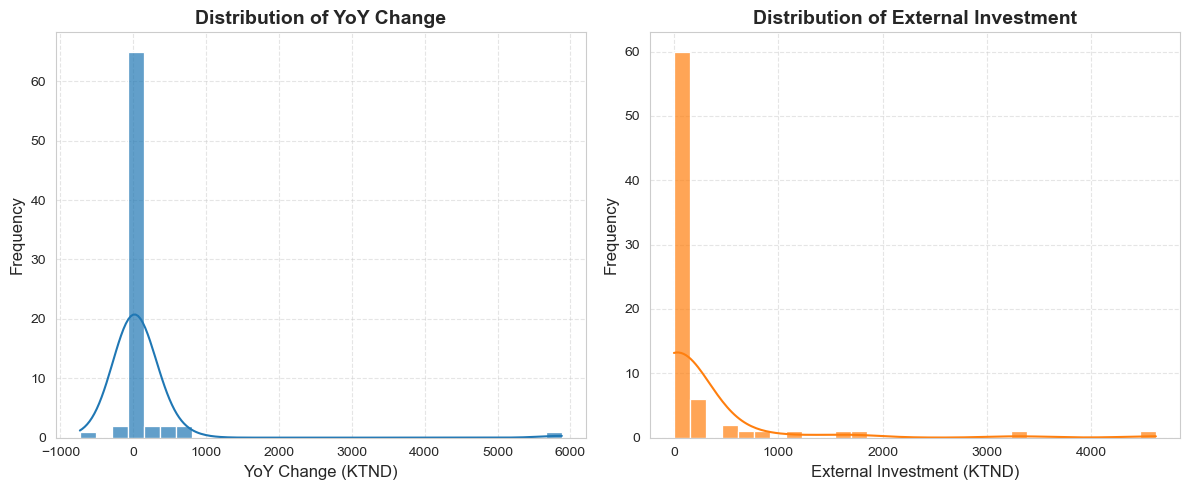

In [11]:

sns.set_style("whitegrid")

#figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#  color palette
colors = ["#1f77b4", "#ff7f0e"]

# Histogram with KDE for YoY Change
sns.histplot(df['YoY_change_KTND'], bins=30, kde=True, color=colors[0], alpha=0.7, ax=ax[0])
ax[0].set_title('Distribution of YoY Change', fontsize=14, fontweight='bold')
ax[0].set_xlabel('YoY Change (KTND)', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.5)

# Histogram with KDE for External Investment
sns.histplot(df['external_investment_1year_after_KTND'], bins=30, kde=True, color=colors[1], alpha=0.7, ax=ax[1])
ax[1].set_title('Distribution of External Investment', fontsize=14, fontweight='bold')
ax[1].set_xlabel('External Investment (KTND)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.5)

# Improve layout
plt.tight_layout()
plt.savefig('enhanced_target_distributions.png', dpi=300)  # Higher resolution
plt.show()



In [12]:
# Check for zero-inflation in target variables
for target in ['YoY_change_KTND', 'external_investment_1year_after_KTND']:
    zeros = (df[target] == 0).sum()
    print(f"\nZeros in {target}: {zeros} ({zeros/len(df)*100:.2f}%)")


Zeros in YoY_change_KTND: 31 (41.33%)

Zeros in external_investment_1year_after_KTND: 54 (72.00%)


In [13]:
## Correlations 

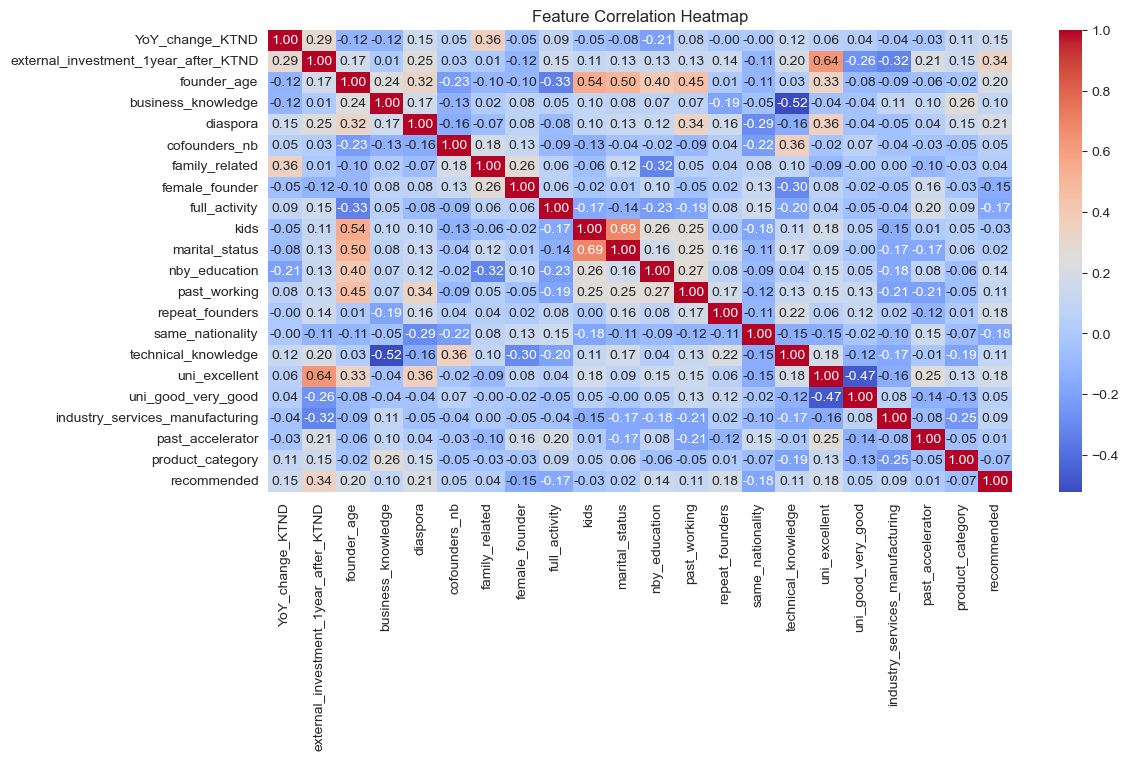

In [14]:
# Correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


Top 5 features correlated with YoY_change_KTND:
family_related: 0.3574
nby_education: -0.2068
recommended: 0.1538
diaspora: 0.1535
technical_knowledge: 0.1210

Top 5 features correlated with external_investment_1year_after_KTND:
uni_excellent: 0.6368
recommended: 0.3391
industry_services_manufacturing: -0.3246
uni_good_very_good: -0.2625
diaspora: 0.2489


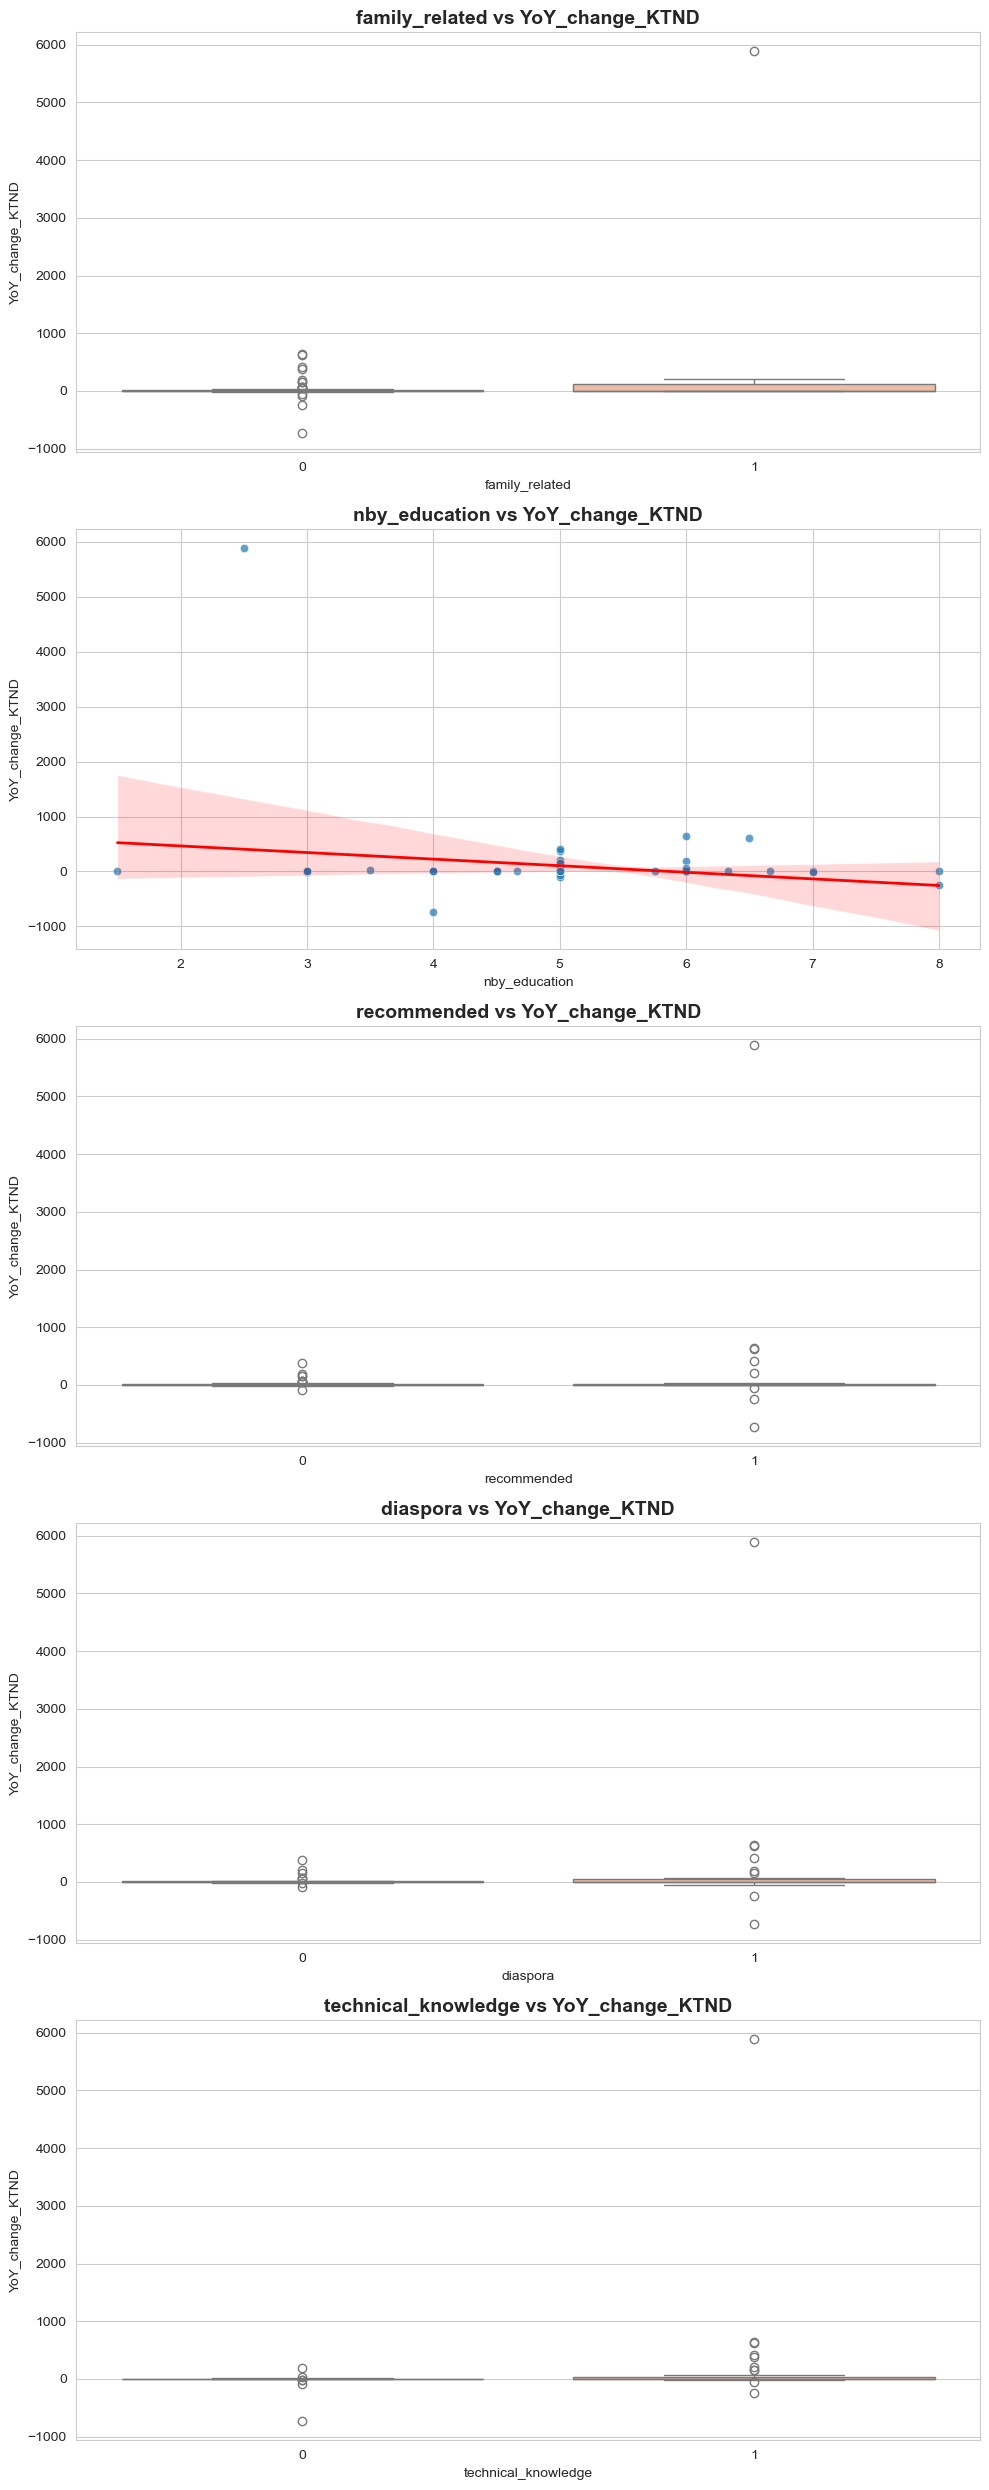

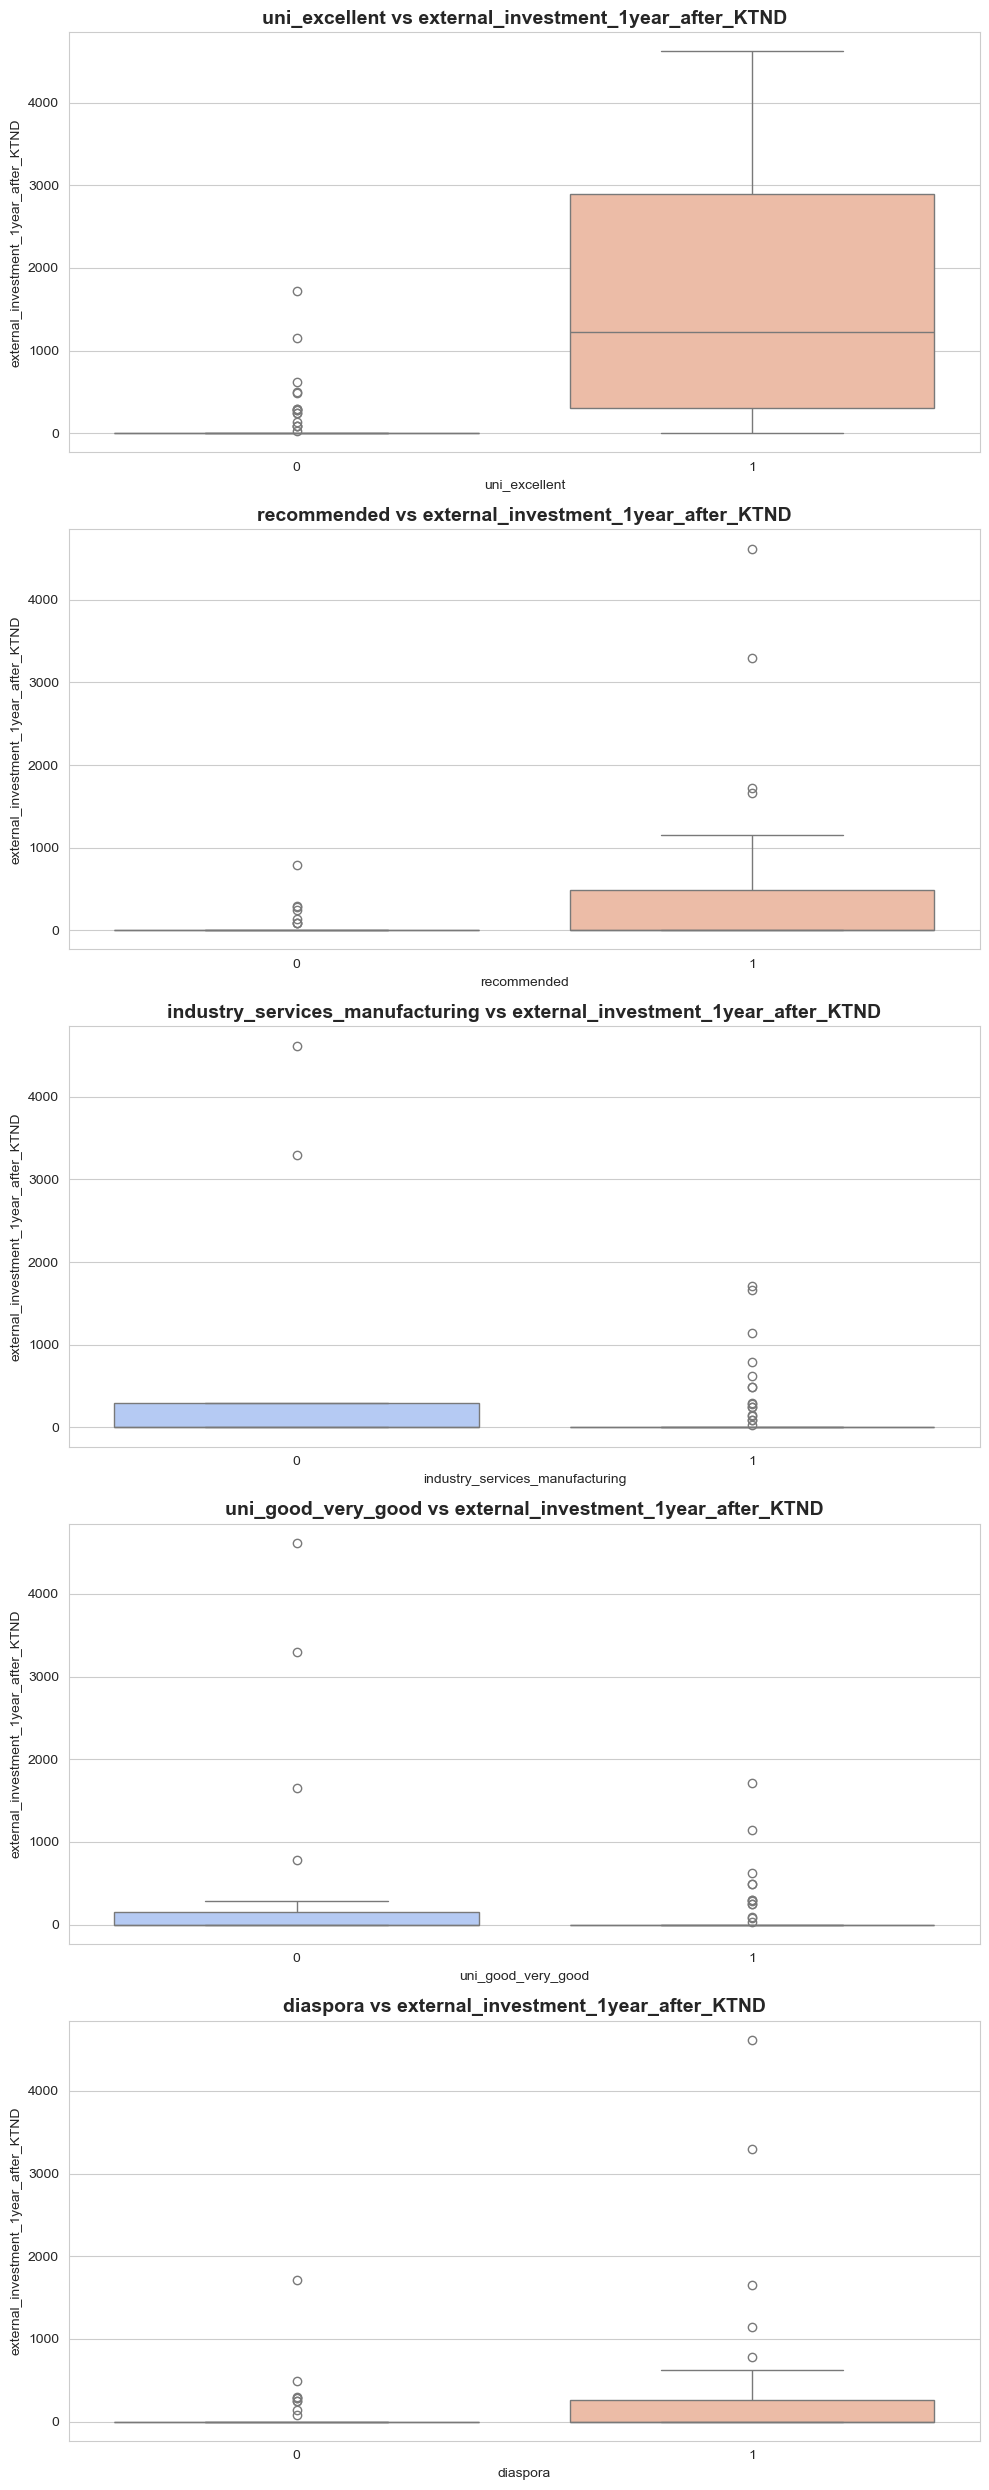

In [15]:
# for better readability
sns.set_style("whitegrid")

# Defining numerical and binary features
numerical_features = ['founder_age', 'cofounders_nb', 'nby_education']
binary_features = [col for col in df.columns if col not in numerical_features +
                   ['YoY_change_KTND', 'external_investment_1year_after_KTND']]

### === 1. Correlation Matrix for Numerical Features === ###
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numerical Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('enhanced_correlation_matrix.png', dpi=300)
plt.close()

### === 2. Correlation with Target Variables === ###
target_corr = pd.DataFrame()

for target in ['YoY_change_KTND', 'external_investment_1year_after_KTND']:
    correlations = {}

    for feature in df.columns:
        if feature not in ['YoY_change_KTND', 'external_investment_1year_after_KTND']:
            corr = df[feature].corr(df[target])
            correlations[feature] = corr

    # Convert to DataFrame, sort by absolute correlation
    sorted_corr = pd.Series(correlations).sort_values(key=abs, ascending=False)
    target_corr[target] = sorted_corr

    # Print top 5 most correlated features
    print(f"\nTop 5 features correlated with {target}:")
    for feature, corr in sorted_corr[:5].items():
        print(f"{feature}: {corr:.4f}")

# Plot feature correlations with target variables
plt.figure(figsize=(12, 6))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlations with Target Variables', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('enhanced_target_correlations.png', dpi=300)
plt.close()

### === 3. Relationship Between Key Features & Targets === ###
for target in ['YoY_change_KTND', 'external_investment_1year_after_KTND']:
    top_features = target_corr[target].abs().nlargest(5).index  # Top 5 correlated features

    fig, axes = plt.subplots(len(top_features), 1, figsize=(10, 5 * len(top_features)))

    for i, feature in enumerate(top_features):
        if feature in numerical_features:
            sns.scatterplot(x=feature, y=target, data=df, ax=axes[i], color="#1f77b4", alpha=0.7)
            sns.regplot(x=feature, y=target, data=df, ax=axes[i], scatter=False, color='red', line_kws={"linewidth": 2})
        else:
            sns.boxplot(x=feature, y=target, data=df, ax=axes[i], hue=feature, palette="coolwarm", legend=False)

        axes[i].set_title(f'{feature} vs {target}', fontsize=14, fontweight='bold')

    plt.tight_layout()

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Combine numerical and binary features for VIF
# Make sure binary features are numeric (0/1)
features_for_vif = numerical_features + binary_features

# Select relevant columns and drop missing if any
X = df[features_for_vif].copy()

# Add intercept for VIF calculation
X['intercept'] = 1

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Exclude intercept from results
vif_data = vif_data[vif_data['feature'] != 'intercept']

print("\nVariance Inflation Factor (VIF) for features:")
print(vif_data.sort_values(by='VIF', ascending=False))


Variance Inflation Factor (VIF) for features:
                            feature       VIF
13              technical_knowledge  2.857148
0                       founder_age  2.794305
8                              kids  2.597362
9                    marital_status  2.535025
14                    uni_excellent  2.200315
3                business_knowledge  1.977983
6                    female_founder  1.755281
10                     past_working  1.727958
4                          diaspora  1.708471
2                     nby_education  1.618981
15               uni_good_very_good  1.603316
1                     cofounders_nb  1.583399
5                    family_related  1.526414
17                 past_accelerator  1.476849
7                     full_activity  1.438889
12                 same_nationality  1.435119
18                 product_category  1.402721
16  industry_services_manufacturing  1.384336
11                  repeat_founders  1.347639
19                      recommend

C:\Users\hibaa\AppData\Local\Temp\ipykernel_35456\1741853634.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


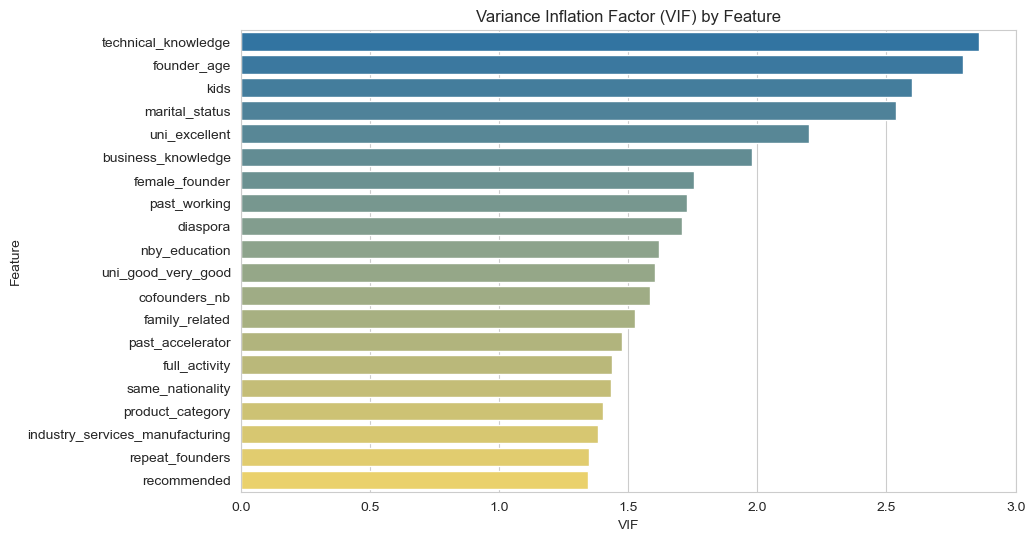

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a custom blue-yellow palette with clear distinct colors
# For a gradient between blue and yellow across all bars:
custom_palette = sns.color_palette("blend:#1f77b4,#ffdd57", n_colors=len(vif_data))

plt.figure(figsize=(10,6))
sns.barplot(
    data=vif_data.sort_values('VIF', ascending=False), 
    x='VIF', y='feature', 
    palette=custom_palette
)
plt.title('Variance Inflation Factor (VIF) by Feature')
plt.xlabel('VIF')
plt.ylabel('Feature')

# Save the figure as a high-resolution PNG file
plt.savefig('vif_by_feature.png', dpi=300, bbox_inches='tight')

plt.show()


In [18]:
## Data Transformation 


Skewness before and after transformation:
YoY_change_KTND: 7.84 -> 0.49
external_investment_1year_after_KTND: 4.56 -> 0.98


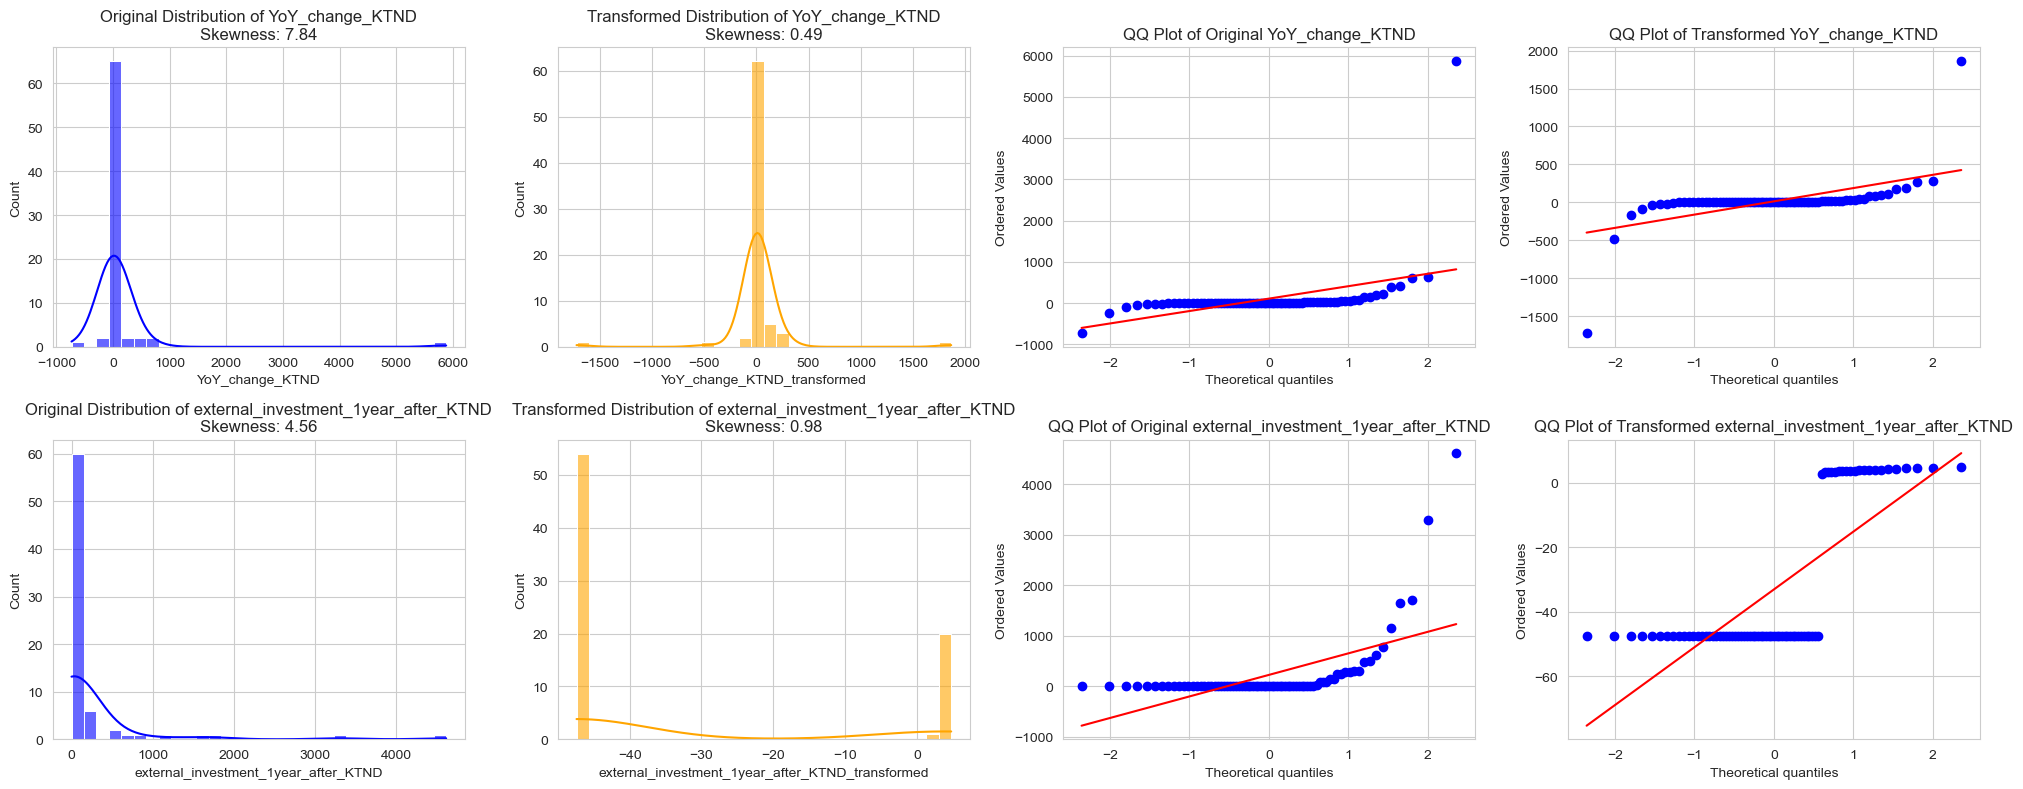

In [19]:

from scipy.stats import yeojohnson, boxcox, skew, probplot

# Defining target variables
target_vars = ['YoY_change_KTND', 'external_investment_1year_after_KTND']

# Copying dataframe to avoid modifying original data
df_transformed = df.copy()

# Applying Yeo-Johnson Transformation to YoY_change_KTND as it contains negative values
df_transformed['YoY_change_KTND_transformed'], _ = yeojohnson(df['YoY_change_KTND'] + 1e-6)

# Applying Box-Cox to external_investment_1year_after_KTND (handling zeros)
df_transformed['external_investment_1year_after_KTND_transformed'], _ = boxcox(df['external_investment_1year_after_KTND'] + 1e-6)

# Check skewness after transformation
print("\nSkewness before and after transformation:")
for var in target_vars:
    transformed_var = f'{var}_transformed'
    original_skewness = skew(df[var])
    transformed_skewness = skew(df_transformed[transformed_var])
    print(f"{var}: {original_skewness:.2f} -> {transformed_skewness:.2f}")

# Visualizations: Histograms & QQ Plots
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

for i, var in enumerate(target_vars):
    transformed_var = f'{var}_transformed'

    # Original Histogram
    sns.histplot(df[var], bins=30, kde=True, ax=axes[i, 0], color="blue", alpha=0.6)
    axes[i, 0].set_title(f'Original Distribution of {var}\nSkewness: {skew(df[var]):.2f}')

    # Transformed Histogram
    sns.histplot(df_transformed[transformed_var], bins=30, kde=True, ax=axes[i, 1], color="orange", alpha=0.6)
    axes[i, 1].set_title(f'Transformed Distribution of {var}\nSkewness: {skew(df_transformed[transformed_var]):.2f}')

    # Original QQ Plot
    probplot(df[var], dist="norm", plot=axes[i, 2])
    axes[i, 2].set_title(f'QQ Plot of Original {var}')

    # Transformed QQ Plot
    probplot(df_transformed[transformed_var], dist="norm", plot=axes[i, 3])
    axes[i, 3].set_title(f'QQ Plot of Transformed {var}')

plt.tight_layout()
plt.show()

# Save transformed dataset
df_transformed.to_csv("transformed_data.csv", index=False)


In [20]:
## Prediction 

In [21]:
## Revenue Growth Prediction :Bayesian Linear Regression : added priors

Initializing NUTS using jitter+adapt_diag...
C:\Users\hibaa\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_founder_age, beta_business_knowledge, beta_diaspora, beta_cofounders_nb, beta_family_related, beta_female_founder, beta_full_activity, beta_kids, beta_marital_status, beta_nby_education, beta_past_working, beta_repeat_founders, beta_same_nationality, beta_technical_knowledge, beta_uni_excellent, beta_uni_good_very_good, beta_industry_services_manufacturing, beta_past_accelerator, beta_product_category, beta_recommended, intercept, sigma]


Output()

Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 1058 seconds.
C:\Users\hibaa\anaconda3\Lib\site-packages\arviz\plots\traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(
C:\Users\hibaa\AppData\Local\Temp\ipykernel_35456\4090058154.py:57: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


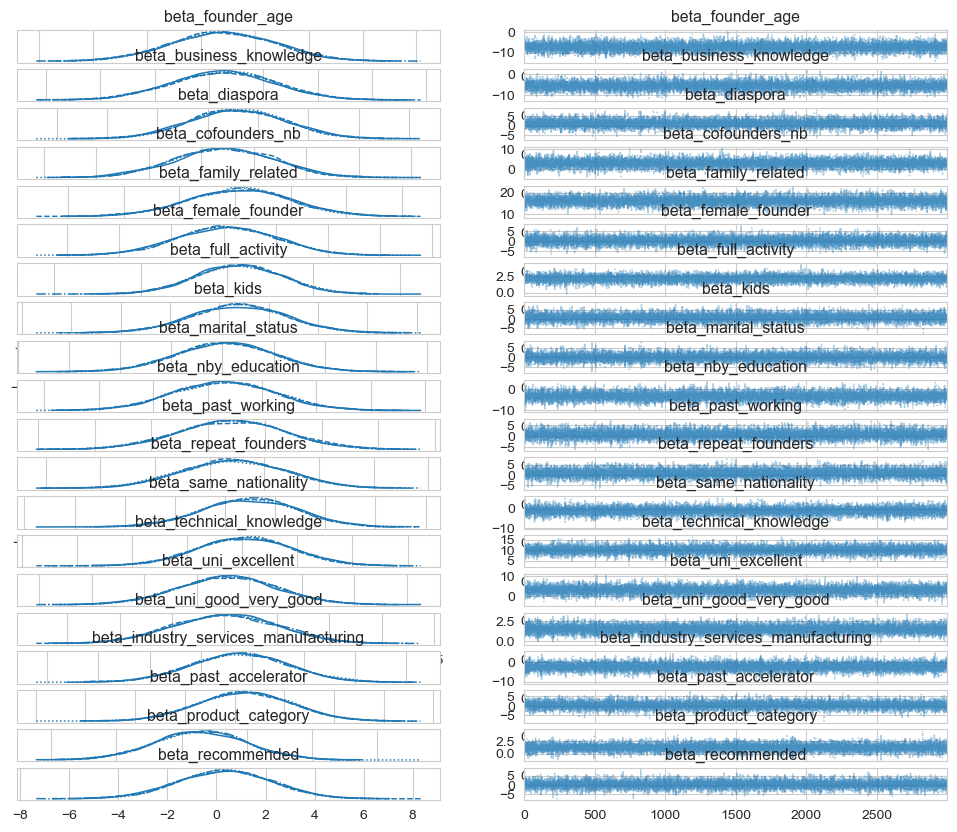

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_founder_age,-7.166,1.916,-10.895,-3.724,0.016,0.018,15136.0,9149.0,1.0
beta_business_knowledge,-5.487,1.887,-9.073,-2.016,0.016,0.017,14326.0,8646.0,1.0
beta_diaspora,1.198,1.893,-2.367,4.680,0.016,0.018,13943.0,8838.0,1.0
beta_cofounders_nb,2.876,1.899,-0.636,6.432,0.015,0.018,17044.0,9134.0,1.0
beta_family_related,16.157,1.838,12.653,19.639,0.015,0.017,15007.0,9120.0,1.0
beta_female_founder,0.125,1.878,-3.458,3.591,0.015,0.017,15124.0,9575.0,1.0
beta_full_activity,2.136,0.500,1.167,3.044,0.004,0.005,14608.0,7298.0,1.0
beta_kids,0.780,1.930,-2.781,4.485,0.016,0.019,14128.0,9188.0,1.0
beta_marital_status,0.135,1.909,-3.576,3.616,0.015,0.019,16049.0,8481.0,1.0
beta_nby_education,-3.390,1.887,-6.848,0.226,0.016,0.018,14330.0,8678.0,1.0


In [22]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv("transformed_data.csv").dropna()  # Drop missing values

# Defining predictors
predictors = ['founder_age', 'business_knowledge', 'diaspora', 'cofounders_nb',
              'family_related', 'female_founder', 'full_activity', 'kids',
              'marital_status', 'nby_education', 'past_working', 'repeat_founders',
              'same_nationality', 'technical_knowledge', 'uni_excellent',
              'uni_good_very_good', 'industry_services_manufacturing',
              'past_accelerator', 'product_category', 'recommended']
X = df[predictors]
y = df['YoY_change_KTND_transformed']

# Standardize predictors
X = (X - X.mean()) / X.std()

# Define Bayesian Linear Regression model
with pm.Model() as YoY_revenue_model:
    # Priors for all predictors (individually named)
    betas = {}
    for col in predictors:
        if col == 'full_activity':
            betas[col] = pm.Normal(f"beta_{col}", mu=2.0, sigma=0.5)
        elif col == 'uni_good_very_good':
            betas[col] = pm.Normal(f"beta_{col}", mu=1.5, sigma=0.5)
        elif col == 'product_category':
            betas[col] = pm.Normal(f"beta_{col}", mu=1.0, sigma=0.7)
        elif col == 'technical_knowledge':
            betas[col] = pm.Normal(f"beta_{col}", mu=5.8, sigma=1.8)
        elif col == 'family_related':
            betas[col] = pm.Normal(f"beta_{col}", mu=8.9, sigma=1.9)
        else:
            betas[col] = pm.Normal(f"beta_{col}", mu=0.0, sigma=2.0)

    # Intercept prior
    intercept = pm.Normal("intercept", mu=0.0, sigma=5.0)

    # Linear model: combine all predictor effects
    mu = intercept
    for col in predictors:
        mu += betas[col] * X[col].values

    # Likelihood
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Sampling
    new_trace_rev = pm.sample(3000, tune=1500, target_accept=0.99, chains=4)

# Plot trace results
az.plot_trace(new_trace_rev, figsize=(12, 10))
plt.tight_layout()
plt.show()

# Display summary statistics
az.summary(new_trace_rev)


In [23]:
## Interpretation of table results:

# mean : On average, a 1-unit increase in "beta" is associated with a "mean of beta" -unit increase in YoY revenue change

# sd :  There is uncertainty around the mean estimate (mean ± sd).

# HDI highest density interval : There’s a 94% probability the true effect of "beta" lies between hdi_3% and hdi_97%. If the interval excludes 0, the effect is "statistically significant" in a Bayesian sense.

# mcse_mean and mcse_sd: Monte Carlo Standard Error (MCSE) for the mean and standard deviation : The uncertainty in estimating the posterior mean (due to finite MCMC samples) is "mcse_mean", and for the posterior sd, it’s "mcs_sd"; if those values are small relative to the mean/sd, the MCMC approximation is precise.

# Effective Sample Size (ESS) for the central part (ess_bulk) and tails (ess_tail) of the posterior.

# The chains produced ~ess_bulk independent samples for estimating the mean/median and ~ess_tail samples for the tails. ESS > 1,000–4,000 is considered reliable, meaning autocorrelation in the chains is minimal.

# r_hat (1.0): The Gelman-Rubin convergence statistic : A value of 1.0 means the chains have perfectly converged to the same posterior distribution. 1.01 is acceptable but 1 is ideal 

In [24]:
## Investment Prediction :Bayesian Logistic Regression

Initializing NUTS using jitter+adapt_diag...
C:\Users\hibaa\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_founder_age, beta_business_knowledge, beta_diaspora, beta_cofounders_nb, beta_family_related, beta_female_founder, beta_full_activity, beta_kids, beta_marital_status, beta_nby_education, beta_past_working, beta_repeat_founders, beta_same_nationality, beta_technical_knowledge, beta_uni_excellent, beta_uni_good_very_good, beta_industry_services_manufacturing, beta_past_accelerator, beta_product_category, beta_recommended, intercept]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1010 seconds.
C:\Users\hibaa\anaconda3\Lib\site-packages\arviz\plots\traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(
C:\Users\hibaa\AppData\Local\Temp\ipykernel_35456\1121960149.py:63: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


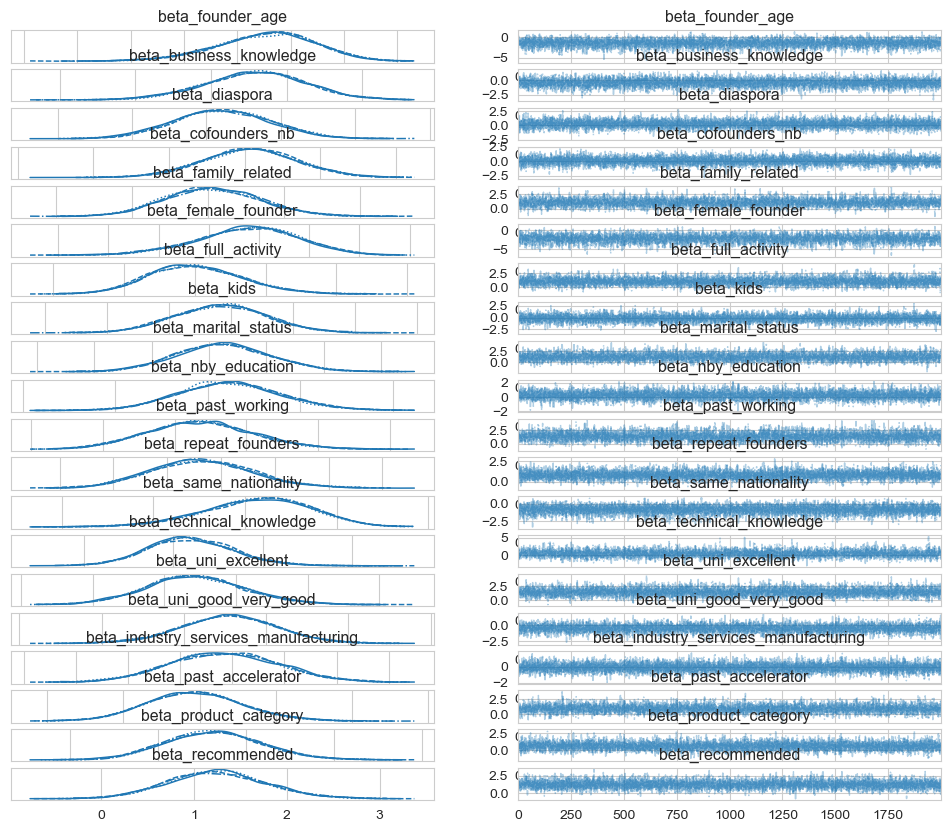

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_founder_age,-1.460,0.917,-3.258,0.173,0.014,0.011,4553.0,4347.0,1.0
beta_business_knowledge,-0.418,0.666,-1.756,0.757,0.009,0.007,5375.0,5133.0,1.0
beta_diaspora,0.220,0.649,-1.013,1.387,0.008,0.007,5963.0,5729.0,1.0
beta_cofounders_nb,0.069,0.634,-1.145,1.234,0.008,0.007,5645.0,5877.0,1.0
beta_family_related,1.067,0.629,-0.104,2.223,0.010,0.007,4065.0,4292.0,1.0
beta_female_founder,-2.226,1.020,-4.204,-0.374,0.018,0.012,3293.0,4655.0,1.0
beta_full_activity,1.016,0.664,-0.215,2.253,0.009,0.008,5936.0,5164.0,1.0
beta_kids,-0.160,0.744,-1.587,1.189,0.010,0.008,5404.0,5185.0,1.0
beta_marital_status,1.265,0.821,-0.240,2.826,0.012,0.009,4643.0,5667.0,1.0
beta_nby_education,0.239,0.561,-0.789,1.321,0.007,0.006,6151.0,4440.0,1.0


In [25]:
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv("transformed_data.csv").dropna()

# Define predictors
predictors = ['founder_age', 'business_knowledge', 'diaspora', 'cofounders_nb',
              'family_related', 'female_founder', 'full_activity', 'kids',
              'marital_status', 'nby_education', 'past_working', 'repeat_founders',
              'same_nationality', 'technical_knowledge', 'uni_excellent',
              'uni_good_very_good', 'industry_services_manufacturing',
              'past_accelerator', 'product_category', 'recommended']
X = df[predictors]

# Convert target to binary based on median threshold
threshold = df['external_investment_1year_after_KTND_transformed'].median()
df['investment_binary'] = (df['external_investment_1year_after_KTND_transformed'] > threshold).astype(int)
y = df['investment_binary']

# Standardize predictors
X = (X - X.mean()) / X.std()

# Define custom priors for selected predictors
special_priors = {
    'uni_excellent': (1.0, 1.0),
    'repeat_founders': (1.0, 1.0),
    'recommended': (1.0, 1.0)
}

# Define Bayesian Logistic Regression model
with pm.Model() as External_investment_model:
    # Priors for coefficients: all have individual beta_<name>
    betas = {}
    for col in predictors:
        if col in special_priors:
            mu, sigma = special_priors[col]
        else:
            mu, sigma = 0.0, 10.0
        betas[col] = pm.Normal(f"beta_{col}", mu=mu, sigma=sigma)

    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0.0, sigma=10.0)

    # Linear model
    mu = intercept
    for col in predictors:
        mu += betas[col] * X[col].values

    # Logistic function for probability
    p = pm.math.sigmoid(mu)

    # Likelihood (Bernoulli distribution)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Sampling
    trace_inv = pm.sample(2000, tune=1000, target_accept=0.99, init="jitter+adapt_diag", chains=4)

# Plot the trace
az.plot_trace(trace_inv, figsize=(12, 10))
plt.tight_layout()
plt.show()

# Display summary statistics
az.summary(trace_inv)


In [26]:
## creating preprocessors 

In [27]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

def create_preprocessors():
    """
    Create preprocessor files for the Bayesian models
    Must be run once before using the Streamlit app
    """
    print("Creating preprocessor files for Bayesian models...")
    
    # Create directory if it doesn't exist
    model_dir = Path("saved_models")
    model_dir.mkdir(exist_ok=True)
    
    # Load the transformed data
    try:
        df = pd.read_csv("transformed_data.csv")
        print(f"Loaded data with {len(df)} rows")
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return False
    
    # Drop missing values
    df = df.dropna()
    print(f"Data after dropping NAs: {len(df)} rows")
    
    # Define predictors - must match those used in model training
    predictors = [
        'founder_age', 'business_knowledge', 'diaspora', 'cofounders_nb',
        'family_related', 'female_founder', 'full_activity', 'kids',
        'marital_status', 'nby_education', 'past_working', 'repeat_founders',
        'same_nationality', 'technical_knowledge', 'uni_excellent',
        'uni_good_very_good', 'industry_services_manufacturing',
        'past_accelerator', 'product_category', 'recommended'
    ]
    
    # Verify all predictors exist in the dataset
    missing_cols = [col for col in predictors if col not in df.columns]
    if missing_cols:
        print(f"Error: Missing columns in dataset: {missing_cols}")
        return False
    
    # Extract predictor data
    X = df[predictors]
    
    # Calculate means and standard deviations for standardization
    X_mean = X.mean()
    X_std = X.std()
    
    # Print some statistics for verification
    print("\nFeature statistics:")
    for col in predictors[:5]:  # Print first 5 as example
        print(f"{col}: mean={X_mean[col]:.4f}, std={X_std[col]:.4f}")
    
    # Create revenue preprocessor dictionary
    revenue_target = 'YoY_change_KTND_transformed'
    if revenue_target not in df.columns:
        print(f"Error: Revenue target column '{revenue_target}' not found in dataset")
        return False
    
    revenue_pp = {
        'predictors': predictors,
        'means': X_mean.to_dict(),
        'stds': X_std.to_dict(),
        'target_mean': df[revenue_target].mean(),
        'target_std': df[revenue_target].std()
    }
    
    # Create investment preprocessor dictionary
    investment_target = 'external_investment_1year_after_KTND_transformed'
    if investment_target not in df.columns:
        print(f"Error: Investment target column '{investment_target}' not found in dataset")
        return False
    
    # Calculate threshold (median) for binary classification
    investment_threshold = df[investment_target].median()
    
    investment_pp = {
        'predictors': predictors,
        'means': X_mean.to_dict(),
        'stds': X_std.to_dict(),
        'threshold': 0.5,  # Probability threshold (0.5 is default for binary classification)
        'target_threshold': investment_threshold  # Original data threshold
    }
    
    # Print target statistics for verification
    print(f"\nRevenue target mean: {revenue_pp['target_mean']:.4f}")
    print(f"Revenue target std: {revenue_pp['target_std']:.4f}")
    print(f"Investment target threshold: {investment_pp['target_threshold']:.4f}")
    
    # Save preprocessors
    try:
        with open(model_dir/"revenue_preprocessor.pkl", "wb") as f:
            pickle.dump(revenue_pp, f)
        
        with open(model_dir/"investment_preprocessor.pkl", "wb") as f:
            pickle.dump(investment_pp, f)
        
        print("\nPreprocessor files created successfully:")
        print(f"- {model_dir/'revenue_preprocessor.pkl'}")
        print(f"- {model_dir/'investment_preprocessor.pkl'}")
        return True
    except Exception as e:
        print(f"Error saving preprocessors: {str(e)}")
        return False

if __name__ == "__main__":
    success = create_preprocessors()
    if success:
        print("\nDone! You can now run the Streamlit app.")
    else:
        print("\nFailed to create preprocessor files. Please check the errors above.")

Creating preprocessor files for Bayesian models...
Loaded data with 75 rows
Data after dropping NAs: 75 rows

Feature statistics:
founder_age: mean=33.6733, std=7.0102
business_knowledge: mean=0.4000, std=0.4932
diaspora: mean=0.4000, std=0.4932
cofounders_nb: mean=1.9067, std=0.9179
family_related: mean=0.0933, std=0.2929

Revenue target mean: 13.8309
Revenue target std: 307.1668
Investment target threshold: -47.3816

Preprocessor files created successfully:
- saved_models\revenue_preprocessor.pkl
- saved_models\investment_preprocessor.pkl

Done! You can now run the Streamlit app.


In [28]:
## saving models 
# run after training

import pickle
import pymc as pm
import arviz as az
from pathlib import Path
import pandas as pd

# Create model directory
model_dir = Path("saved_models")
model_dir.mkdir(exist_ok=True)

# Save Revenue Model
az.to_netcdf(new_trace_rev, model_dir/"new_revenue_model.nc")
pickle.dump({
    'means': X.mean(),
    'stds': X.std(),
    'predictors': predictors
}, open(model_dir/"revenue_preprocessor.pkl", "wb"))

# Save Investment Model
az.to_netcdf(trace_inv, model_dir/"investment_model.nc")
pickle.dump({
    'means': X.mean(),  # From classification 
    'stds': X.std(),
    'predictors': predictors,
    'threshold': threshold
}, open(model_dir/"investment_preprocessor.pkl", "wb"))

In [29]:
# Making Predictions 

Enter values for each predictor:


founder_age (22.67 - 58.5):  35
business_knowledge (0 - 1):  1
diaspora (0 - 1):  1
cofounders_nb (1 - 4):  2
family_related (0 - 1):  1
female_founder (0 - 1):  0
full_activity (0 - 1):  1
kids (0 - 1):  0
marital_status (0 - 1):  0
nby_education (1.5 - 8.0):  6
past_working (0 - 1):  1
repeat_founders (0 - 1):  1
same_nationality (0 - 1):  1
technical_knowledge (0 - 1):  1
uni_excellent (0 - 1):  1
uni_good_very_good (0 - 1):  1
industry_services_manufacturing (0 - 1):  0
past_accelerator (0 - 1):  1
product_category (0 - 1):  1
recommended (0 - 1):  1



📊 Bayesian Predictions:
• YoY Change: 23.3K TND
  89% HDI: 15.7K to 30.9K

• Investment Probability: 99.7%
  89% HDI: 99.9% to 100.0%
  Predicted Class: High confidence


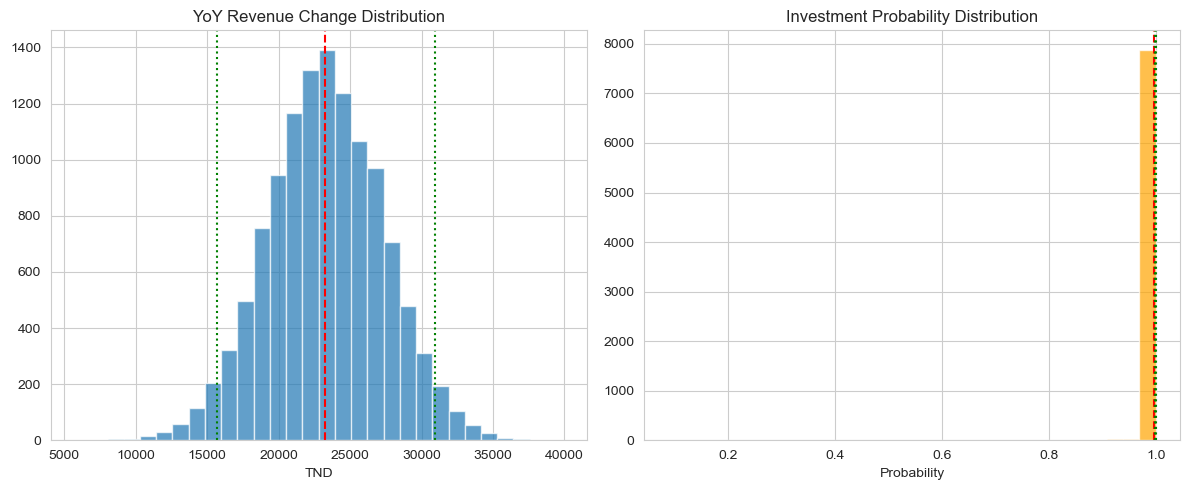

In [30]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Load and clean data
df_original = pd.read_csv("transformed_data.csv").dropna()
predictors = [
    'founder_age', 'business_knowledge', 'diaspora', 'cofounders_nb',
    'family_related', 'female_founder', 'full_activity', 'kids',
    'marital_status', 'nby_education', 'past_working', 'repeat_founders',
    'same_nationality', 'technical_knowledge', 'uni_excellent',
    'uni_good_very_good', 'industry_services_manufacturing',
    'past_accelerator', 'product_category', 'recommended'
]

# Standardization parameters
X_train = df_original[predictors]
train_mean = X_train.mean()
train_std = X_train.std()

# Get user input
input_data = {}
print("Enter values for each predictor:")
for predictor in predictors:
    min_val = df_original[predictor].min()
    max_val = df_original[predictor].max()
    
    while True:
        try:
            value = float(input(f"{predictor} ({min_val} - {max_val}): "))
            if min_val <= value <= max_val:
                input_data[predictor] = value
                break
            else:
                print(f"⚠️ Value must be between {min_val} and {max_val}. Try again.")
        except ValueError:
            print("❌ Invalid input. Please enter a number.")

# Prediction function (revenue)
def predict_yoy_revenue(trace, new_data, X_mean, X_std):
    new_df = pd.DataFrame([new_data])
    new_df_std = (new_df - X_mean) / X_std

    intercept = trace.posterior['intercept'].values.flatten()

    mu_samples = intercept.copy()
    for var in new_df_std.columns:
        beta_name = f'beta_{var}'
        if beta_name in trace.posterior:
            beta = trace.posterior[beta_name].values.flatten()
            mu_samples += beta * new_df_std[var].values[0]

    return {
        'samples': mu_samples,
        'mean': np.mean(mu_samples),
        'hdi': az.hdi(mu_samples, hdi_prob=0.89)
    }

# Prediction function (investment)
def predict_investment(trace, new_data, X_mean, X_std):
    new_df = pd.DataFrame([new_data])
    new_df_std = (new_df - X_mean) / X_std

    intercept = trace.posterior['intercept'].values.flatten()

    logit_samples = intercept.copy()
    for var in new_df_std.columns:
        beta_name = f'beta_{var}'
        if beta_name in trace.posterior:
            beta = trace.posterior[beta_name].values.flatten()
            logit_samples += beta * new_df_std[var].values[0]

    prob_samples = 1 / (1 + np.exp(-logit_samples))

    return {
        'samples': prob_samples,
        'mean': np.mean(prob_samples),
        'hdi': az.hdi(prob_samples, hdi_prob=0.89),
        'class': 1 if np.mean(prob_samples) > 0.5 else 0
    }

# Run predictions
yoy_result = predict_yoy_revenue(new_trace_rev, input_data, train_mean, train_std)
inv_result = predict_investment(trace_inv, input_data, train_mean, train_std)

# Convert revenue to original scale
yoy_original = (yoy_result['samples'] *
                df_original['YoY_change_KTND_transformed'].std() +
                df_original['YoY_change_KTND_transformed'].mean())

# Display results
print("\n📊 Bayesian Predictions:")
print(f"• YoY Change: {yoy_original.mean()/1000:.1f}K TND")
print(f"  89% HDI: {az.hdi(yoy_original)[0]/1000:.1f}K to {az.hdi(yoy_original)[1]/1000:.1f}K")

print(f"\n• Investment Probability: {inv_result['mean']:.1%}")
print(f"  89% HDI: {inv_result['hdi'][0]:.1%} to {inv_result['hdi'][1]:.1%}")
print(f"  Predicted Class: {'High' if inv_result['class'] else 'Low'} confidence")

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(yoy_original, bins=30, alpha=0.7)
ax1.set_title('YoY Revenue Change Distribution')
ax1.set_xlabel('TND')
ax1.axvline(yoy_original.mean(), color='red', linestyle='--')
ax1.axvline(az.hdi(yoy_original)[0], color='green', linestyle=':')
ax1.axvline(az.hdi(yoy_original)[1], color='green', linestyle=':')

ax2.hist(inv_result['samples'], bins=30, alpha=0.7, color='orange')
ax2.set_title('Investment Probability Distribution')
ax2.set_xlabel('Probability')
ax2.axvline(inv_result['mean'], color='red', linestyle='--')
ax2.axvline(inv_result['hdi'][0], color='green', linestyle=':')
ax2.axvline(inv_result['hdi'][1], color='green', linestyle=':')

plt.tight_layout()
plt.show()


In [31]:
## Revenue : The model is cautious needing improvments, provides useful estimates, but with moderate uncertainty.The histogram is roughly symmetric with a small positive skew. The red dashed line marks the mean prediction. Green dashed lines are 89% HDI bounds.
## Investment : The model is reliable. The distribution is sharply concentrated near 1.0, with very low spread (predictions do not vary much and are clustered tightly together).The tight HDI (above 90%) shows strong certainty.The signal-to-noise is good (the model is picking up clear patterns)

In [32]:
## Model Evaluation 

In [33]:
## R-hat (Convergence Check): Ensure all R-hat values are close to 1 (≤ 1.01), 
## which indicates good convergence and verify that  MCMC chains have properly converged to the posterior distribution.

In [34]:
print("R-hat values for YoY revenue model:")
print(az.rhat(new_trace_rev))

print("\nR-hat values for Investment model:")
print(az.rhat(trace_inv))


R-hat values for YoY revenue model:
<xarray.Dataset>
Dimensions:                               ()
Data variables: (12/22)
    beta_founder_age                      float64 1.001
    beta_business_knowledge               float64 1.0
    beta_diaspora                         float64 1.001
    beta_cofounders_nb                    float64 0.9999
    beta_family_related                   float64 1.001
    beta_female_founder                   float64 1.0
    ...                                    ...
    beta_industry_services_manufacturing  float64 1.0
    beta_past_accelerator                 float64 1.0
    beta_product_category                 float64 1.0
    beta_recommended                      float64 1.001
    intercept                             float64 1.0
    sigma                                 float64 1.0

R-hat values for Investment model:
<xarray.Dataset>
Dimensions:                               ()
Data variables: (12/21)
    beta_founder_age                      float64 

In [35]:
## Effective Sample Size (ESS) (a low value indicates sampling issues)

In [36]:
print("ESS for YoY revenue model:")
print(az.ess(new_trace_rev))

print("\nESS for Investment model:")
print(az.ess(trace_inv))


ESS for YoY revenue model:
<xarray.Dataset>
Dimensions:                               ()
Data variables: (12/22)
    beta_founder_age                      float64 1.514e+04
    beta_business_knowledge               float64 1.433e+04
    beta_diaspora                         float64 1.394e+04
    beta_cofounders_nb                    float64 1.704e+04
    beta_family_related                   float64 1.501e+04
    beta_female_founder                   float64 1.512e+04
    ...                                    ...
    beta_industry_services_manufacturing  float64 1.429e+04
    beta_past_accelerator                 float64 1.352e+04
    beta_product_category                 float64 1.465e+04
    beta_recommended                      float64 1.571e+04
    intercept                             float64 1.376e+04
    sigma                                 float64 1.534e+04

ESS for Investment model:
<xarray.Dataset>
Dimensions:                               ()
Data variables: (12/21)
    bet

In [37]:
## Revenue model performance 

C:\Users\hibaa\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sampling: [y_obs]


Output()

✅ Mean Squared Error (MSE) (posterior distribution): 3311.81
✅ Mean Absolute Error (MAE) (posterior distribution): 45.75
✅ Mean Squared Error (MSE) (point estimate): 713.45
✅ Mean Absolute Error (MAE) (point estimate): 19.84
✅ R² (point estimate): -3537.95
✅ RMSE (point estimate): 26.71


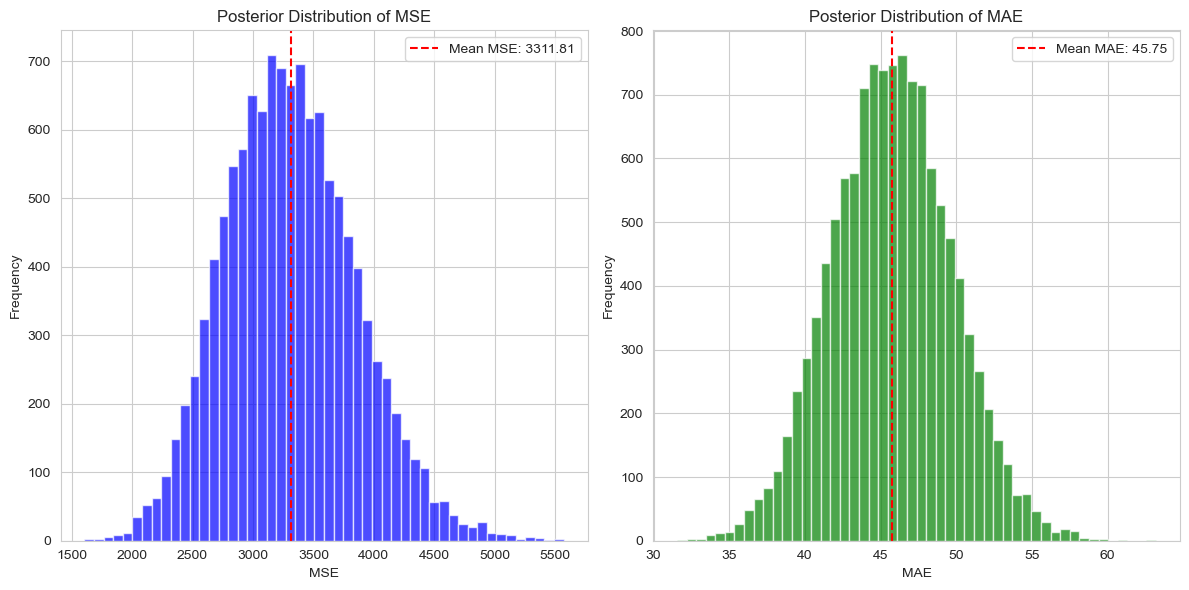


Bayesian R²:
Mean: 0.501
Std: 0.000
94% HDI: [0.500, 0.501]


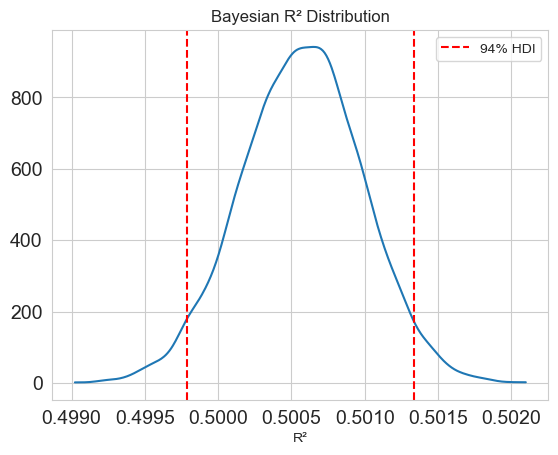

In [38]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the trace from your existing model
# Assuming 'new_trace_rev' is your trace object from the model
# and 'y' is your observed data (length n_obs)

# 1. Generate posterior predictive samples
with YoY_revenue_model:
    posterior_pred = pm.sample_posterior_predictive(new_trace_rev, var_names=["y_obs"], return_inferencedata=False)

# 2. Reshape posterior predictions to (samples, observations)
y_pred_samples = posterior_pred["y_obs"].reshape(-1, posterior_pred["y_obs"].shape[-1])

# 3. Ensure the observed data (y) is a numpy array
y_array = np.asarray(y)
y_broadcasted = np.broadcast_to(y_array, y_pred_samples.shape)

# 4. Calculate MSE for each posterior sample
mse_samples = np.mean((y_pred_samples - y_broadcasted) ** 2, axis=1)

# 5. Calculate MAE for each posterior sample
mae_samples = np.mean(np.abs(y_pred_samples - y_broadcasted), axis=1)

# 6. Calculate mean MSE and MAE
mean_mse = np.mean(mse_samples)
mean_mae = np.mean(mae_samples)

# 7. Print MSE and MAE for the entire posterior distribution
print(f"✅ Mean Squared Error (MSE) (posterior distribution): {mean_mse:.2f}")
print(f"✅ Mean Absolute Error (MAE) (posterior distribution): {mean_mae:.2f}")

# 8. Classical evaluation metrics (mean prediction as point estimate)
y_pred_mean = y_pred_samples.mean(axis=0)  # Mean over all posterior samples

# Classical MSE and MAE (point estimate)
mse_point_estimate = mean_squared_error(y, y_pred_mean)
mae_point_estimate = mean_absolute_error(y, y_pred_mean)

# Classical R² and RMSE (point estimate)
r2_point_estimate = r2_score(y, y_pred_mean)
rmse_point_estimate = np.sqrt(mse_point_estimate)

print(f"✅ Mean Squared Error (MSE) (point estimate): {mse_point_estimate:.2f}")
print(f"✅ Mean Absolute Error (MAE) (point estimate): {mae_point_estimate:.2f}")
print(f"✅ R² (point estimate): {r2_point_estimate:.2f}")
print(f"✅ RMSE (point estimate): {rmse_point_estimate:.2f}")

# 9. Plot the posterior distribution of MSE and MAE
plt.figure(figsize=(12, 6))

# MSE distribution plot
plt.subplot(1, 2, 1)
plt.hist(mse_samples, bins=50, color='blue', alpha=0.7)
plt.axvline(mean_mse, color='red', linestyle='--', label=f'Mean MSE: {mean_mse:.2f}')
plt.title('Posterior Distribution of MSE')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.legend()

# MAE distribution plot
plt.subplot(1, 2, 2)
plt.hist(mae_samples, bins=50, color='green', alpha=0.7)
plt.axvline(mean_mae, color='red', linestyle='--', label=f'Mean MAE: {mean_mae:.2f}')
plt.title('Posterior Distribution of MAE')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# 10. Bayesian R² calculation (same as before)
y_broadcasted = np.broadcast_to(y_array, y_pred_samples.shape)
bayes_r2_samples = az.r2_samples(y_broadcasted, y_pred_samples)

bayes_r2_mean = bayes_r2_samples.mean()
bayes_r2_std = bayes_r2_samples.std()
bayes_r2_hdi = az.hdi(bayes_r2_samples, hdi_prob=0.94)

print("\nBayesian R²:")
print(f"Mean: {bayes_r2_mean:.3f}")
print(f"Std: {bayes_r2_std:.3f}")
print(f"94% HDI: [{bayes_r2_hdi[0]:.3f}, {bayes_r2_hdi[1]:.3f}]")

# 11. Plot Bayesian R² distribution
az.plot_dist(bayes_r2_samples)
plt.axvline(bayes_r2_hdi[0], color='red', linestyle='--', label='94% HDI')
plt.axvline(bayes_r2_hdi[1], color='red', linestyle='--')
plt.title('Bayesian R² Distribution')
plt.xlabel('R²')
plt.legend()
plt.show()


In [39]:
hdi = az.hdi(posterior_pred["y_obs"], hdi_prob=0.9)
coverage = ((y >= hdi[:, 0]) & (y <= hdi[:, 1])).mean()
print(f"Coverage (90% interval): {coverage:.2%}")

Coverage (90% interval): 100.00%


In [40]:
## Evaluating posterior distributions (checking the model fit)

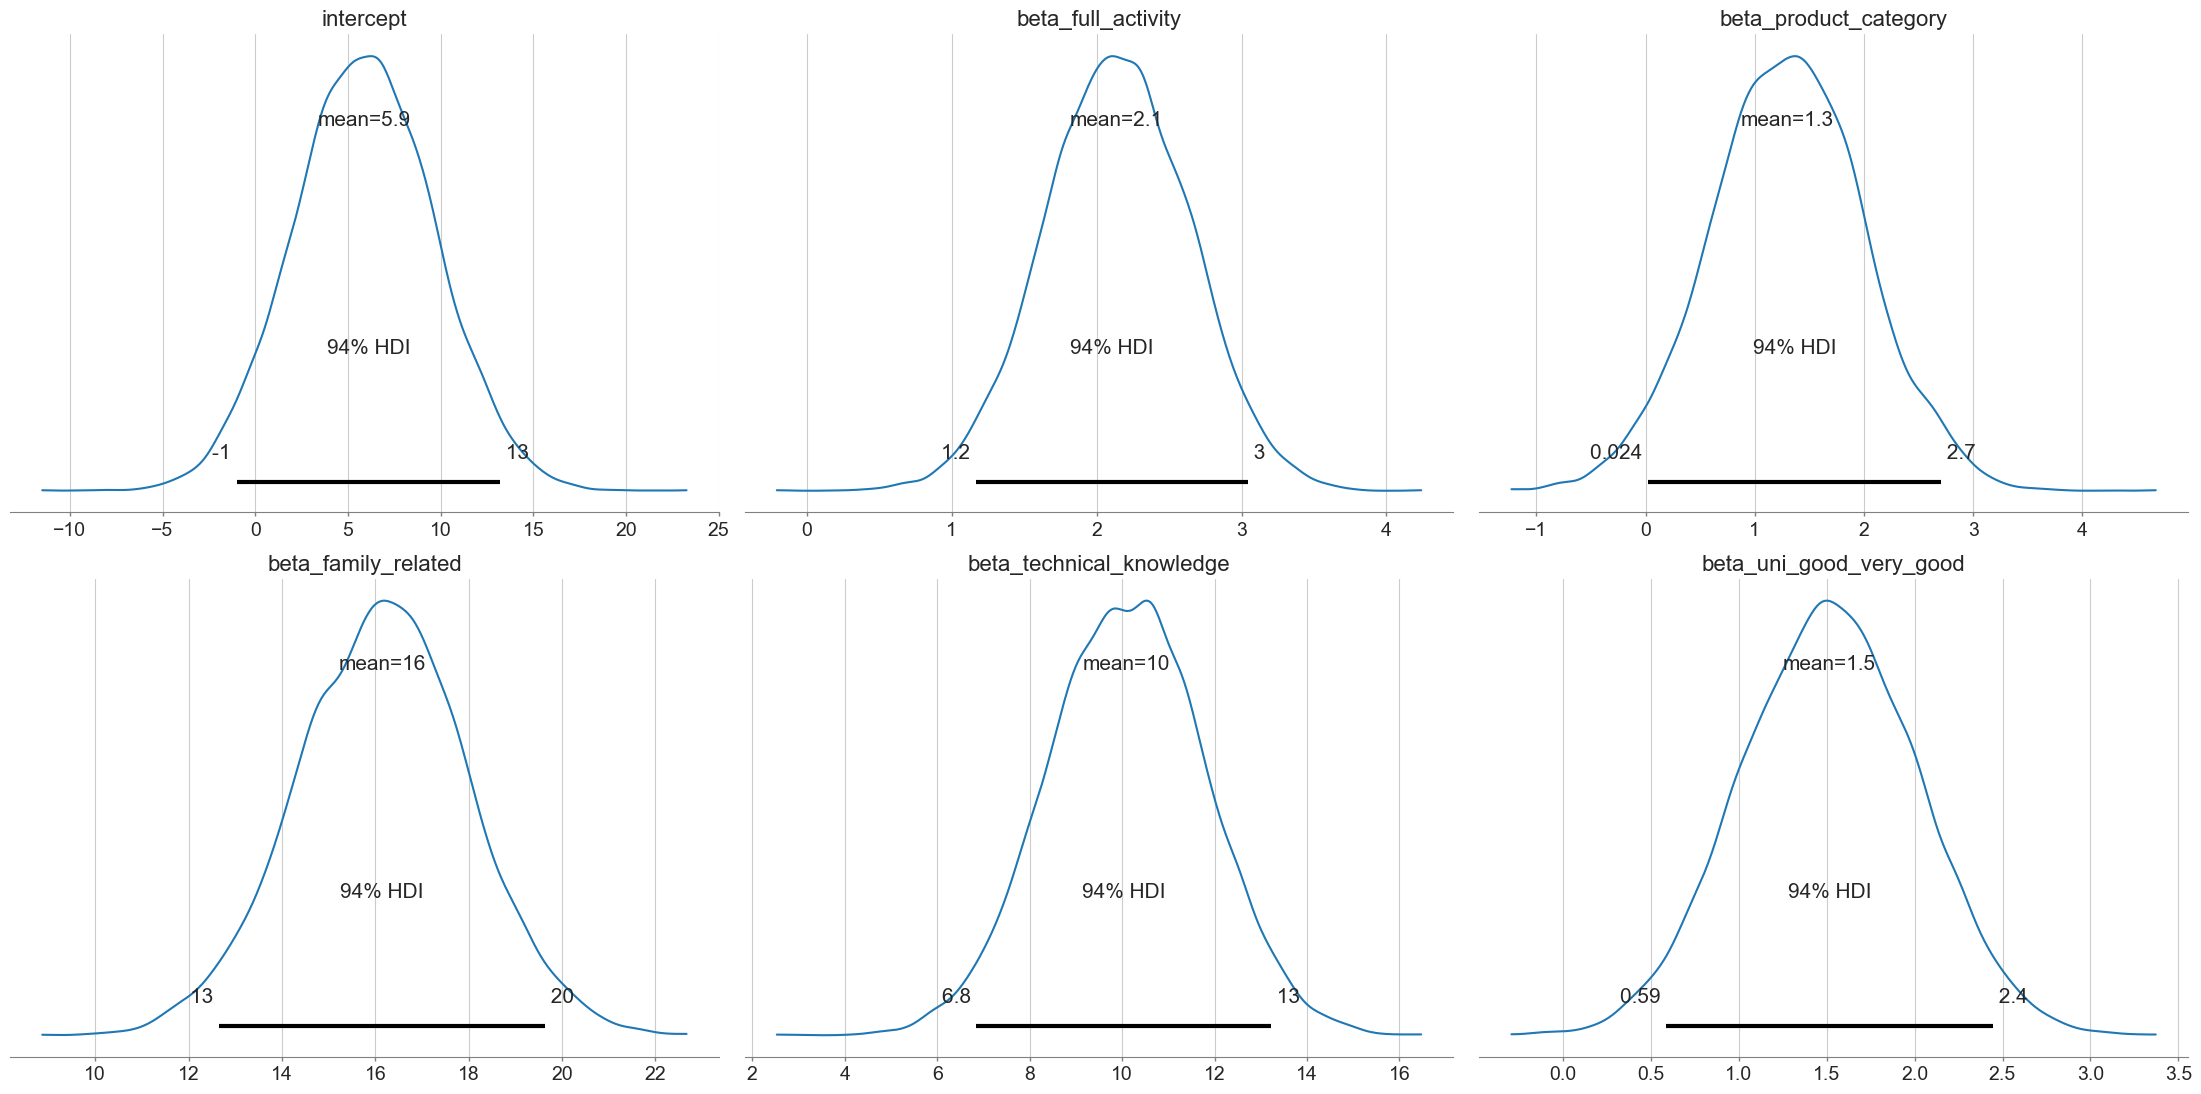

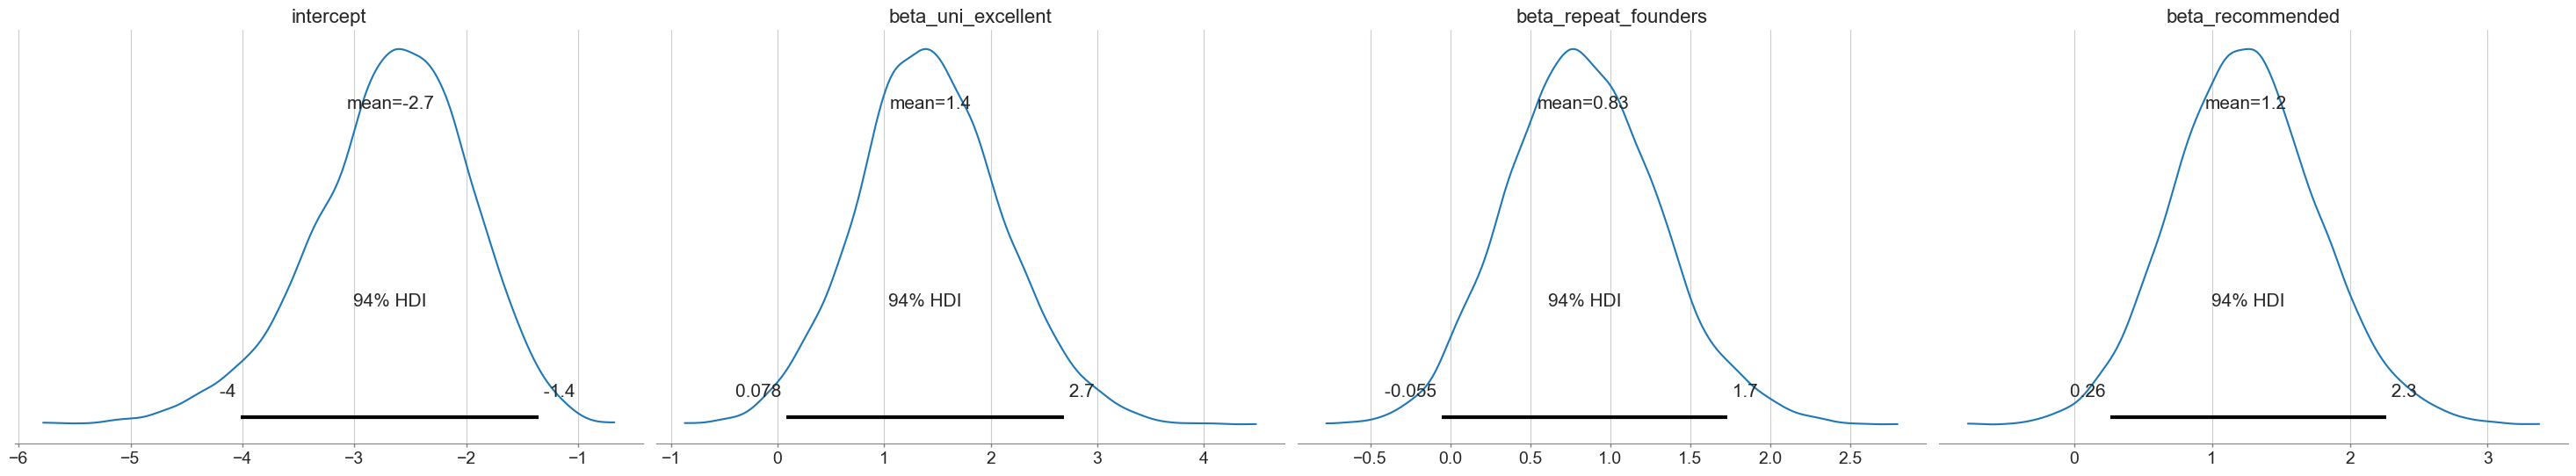

In [41]:
# For the first plot
az.plot_posterior(new_trace_rev, var_names=['intercept', 'beta_full_activity', 'beta_product_category','beta_family_related', 'beta_technical_knowledge', 'beta_uni_good_very_good'])
plt.tight_layout()  # Ensures all elements fit properly
plt.savefig('posterior_plot_1.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()

# For the second plot
az.plot_posterior(trace_inv, var_names=['intercept', 'beta_uni_excellent', 'beta_repeat_founders','beta_recommended'])
plt.tight_layout()  # Ensures all elements fit properly
plt.savefig('posterior_plot_2.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()

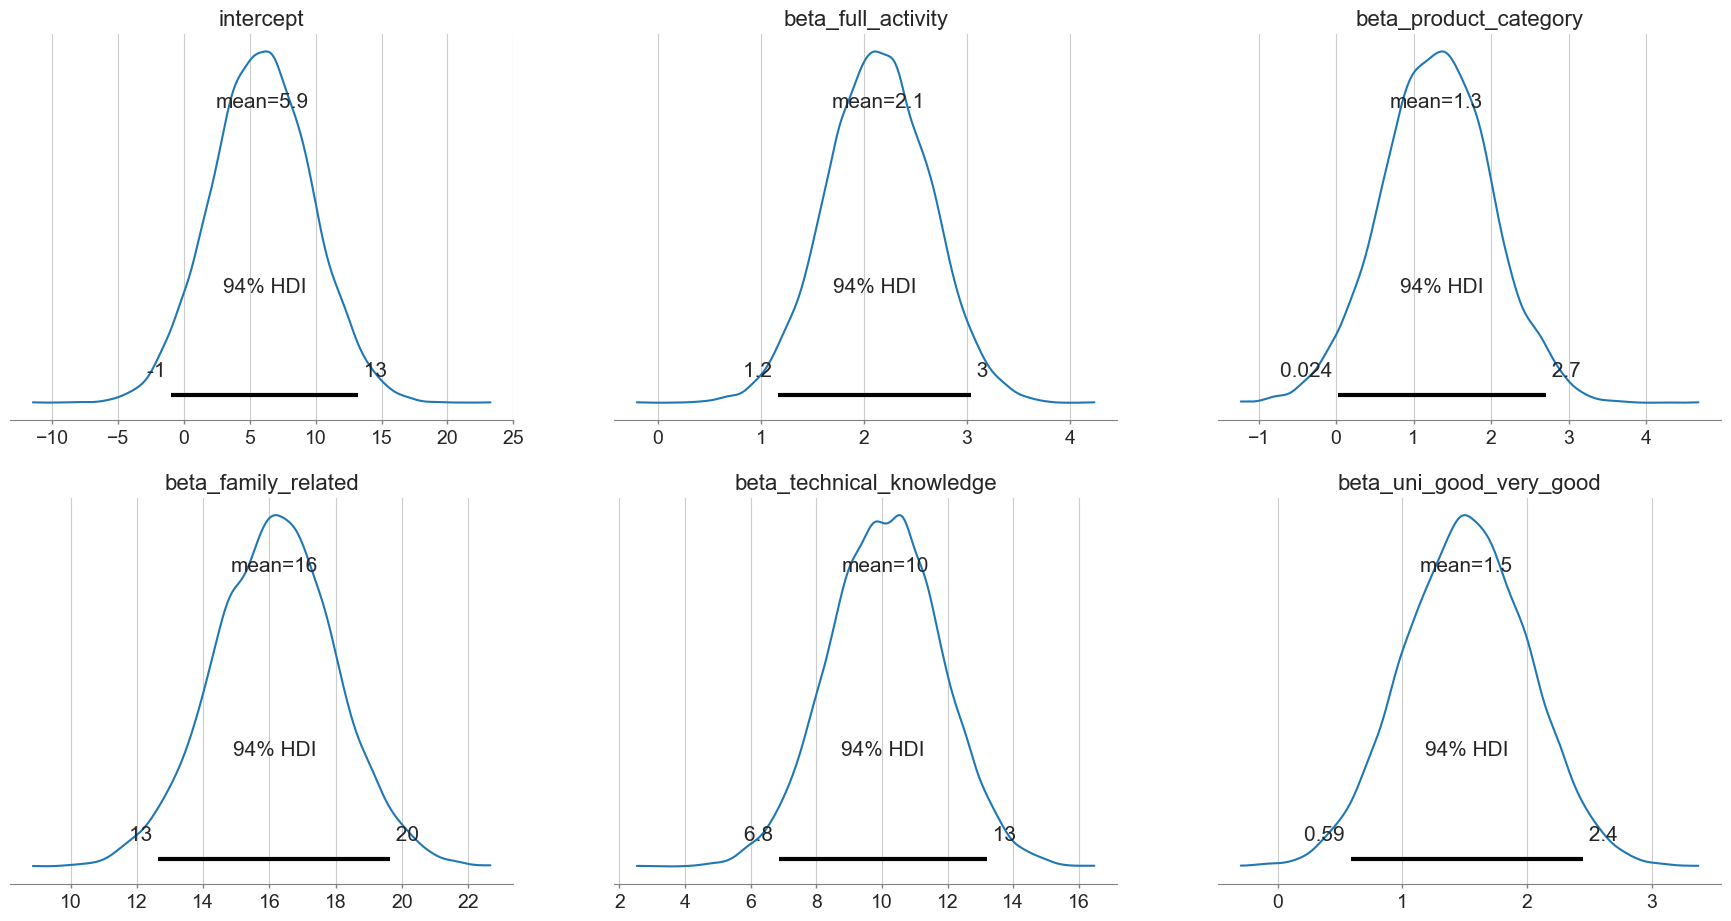

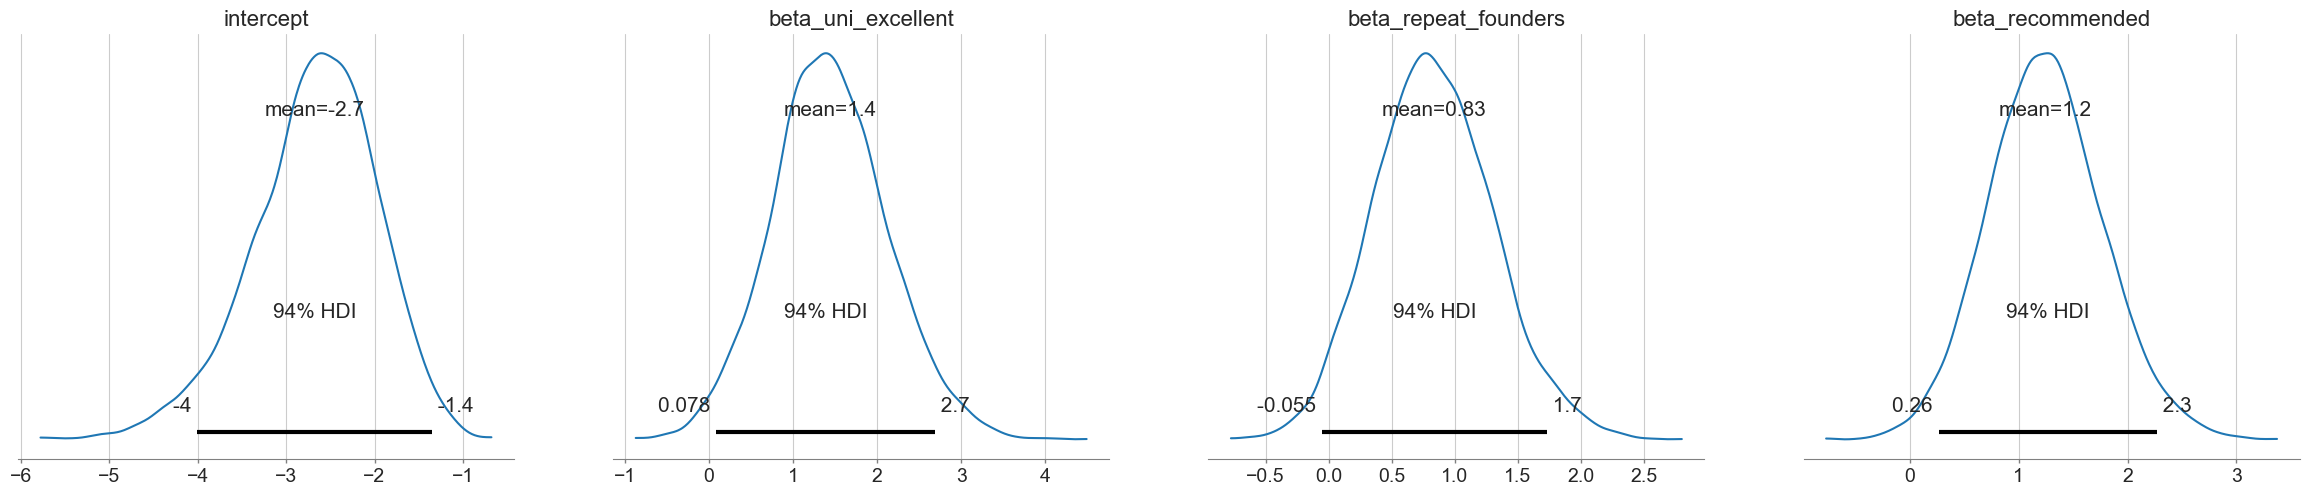

In [42]:
az.plot_posterior(new_trace_rev, var_names=['intercept', 'beta_full_activity', 'beta_product_category','beta_family_related' , 'beta_technical_knowledge' , 'beta_uni_good_very_good'])
plt.show()

az.plot_posterior(trace_inv, var_names=['intercept', 'beta_uni_excellent', 'beta_repeat_founders','beta_recommended'])
plt.show()


In [43]:
# Strongly significant predictors: full_activity, product_category, and uni_excellent (since their HDIs do not include 0).

# Uncertain predictor: repeat_founders (since its HDI includes 0, meaning its effect could be negligible or even slightly negative).

# Intercept values vary, suggesting different baseline effects for different models or groups.

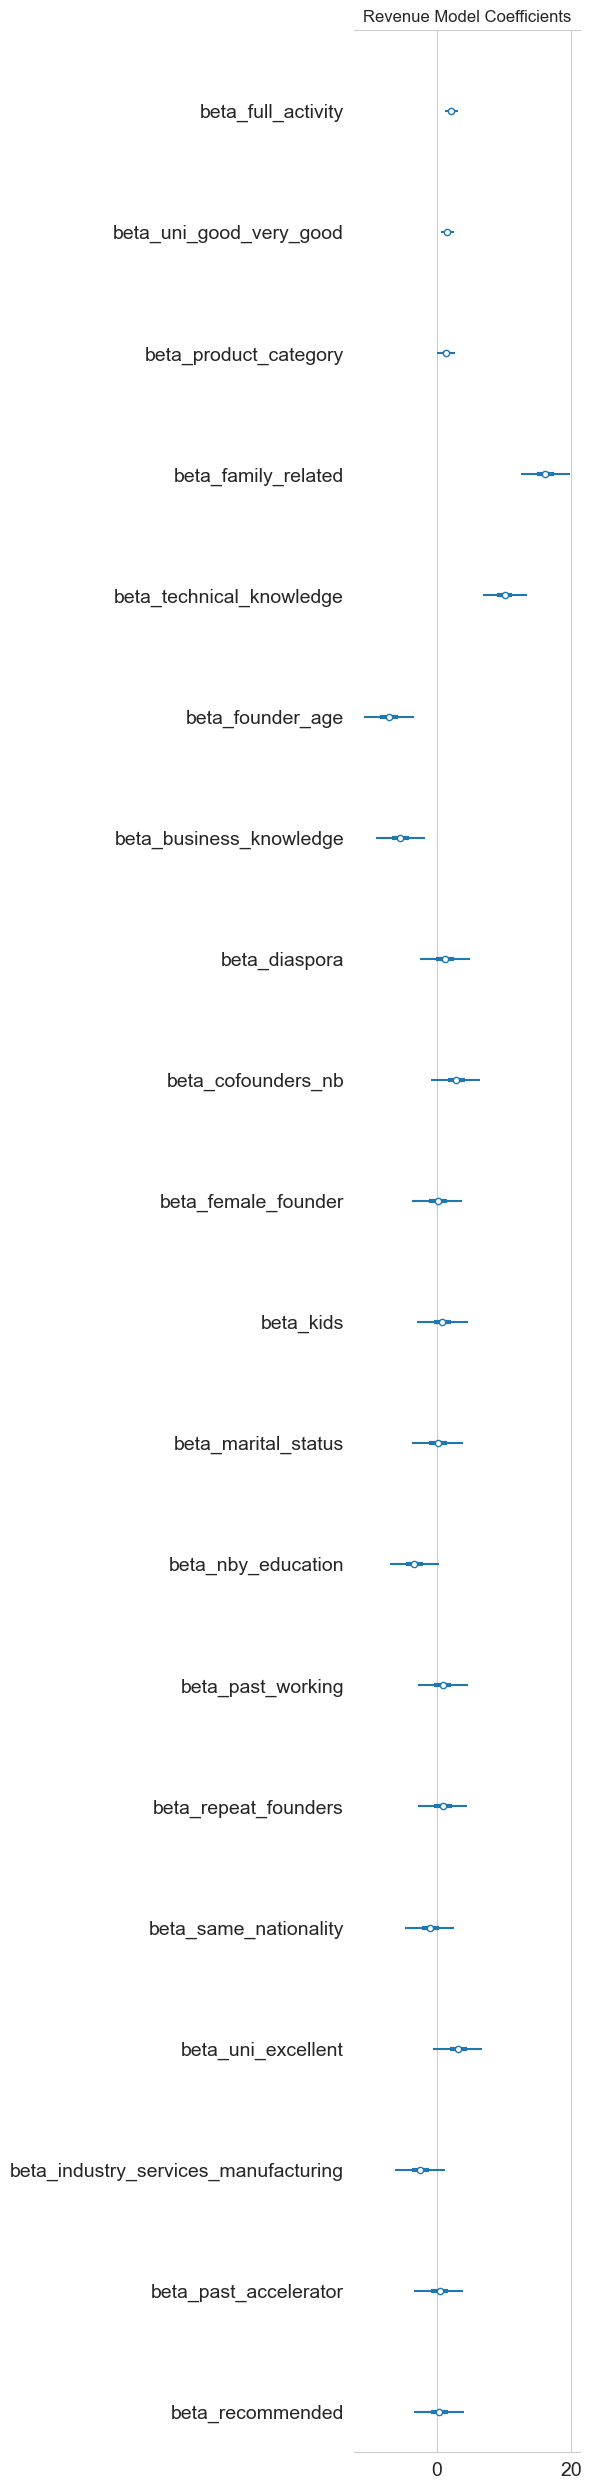

Probability that beta_full_activity coefficient > 0: 1.000
Probability that beta_uni_good_very_good coefficient > 0: 0.999
Probability that beta_product_category coefficient > 0: 0.965
Probability that beta_family_related coefficient > 0: 1.000
Probability that beta_technical_knowledge coefficient > 0: 1.000
Probability that beta_founder_age coefficient > 0: 0.000
Probability that beta_business_knowledge coefficient > 0: 0.002
Probability that beta_diaspora coefficient > 0: 0.735
Probability that beta_cofounders_nb coefficient > 0: 0.933
Probability that beta_female_founder coefficient > 0: 0.524
Probability that beta_kids coefficient > 0: 0.661
Probability that beta_marital_status coefficient > 0: 0.529
Probability that beta_nby_education coefficient > 0: 0.037
Probability that beta_past_working coefficient > 0: 0.670
Probability that beta_repeat_founders coefficient > 0: 0.679
Probability that beta_same_nationality coefficient > 0: 0.300
Probability that beta_uni_excellent coefficien

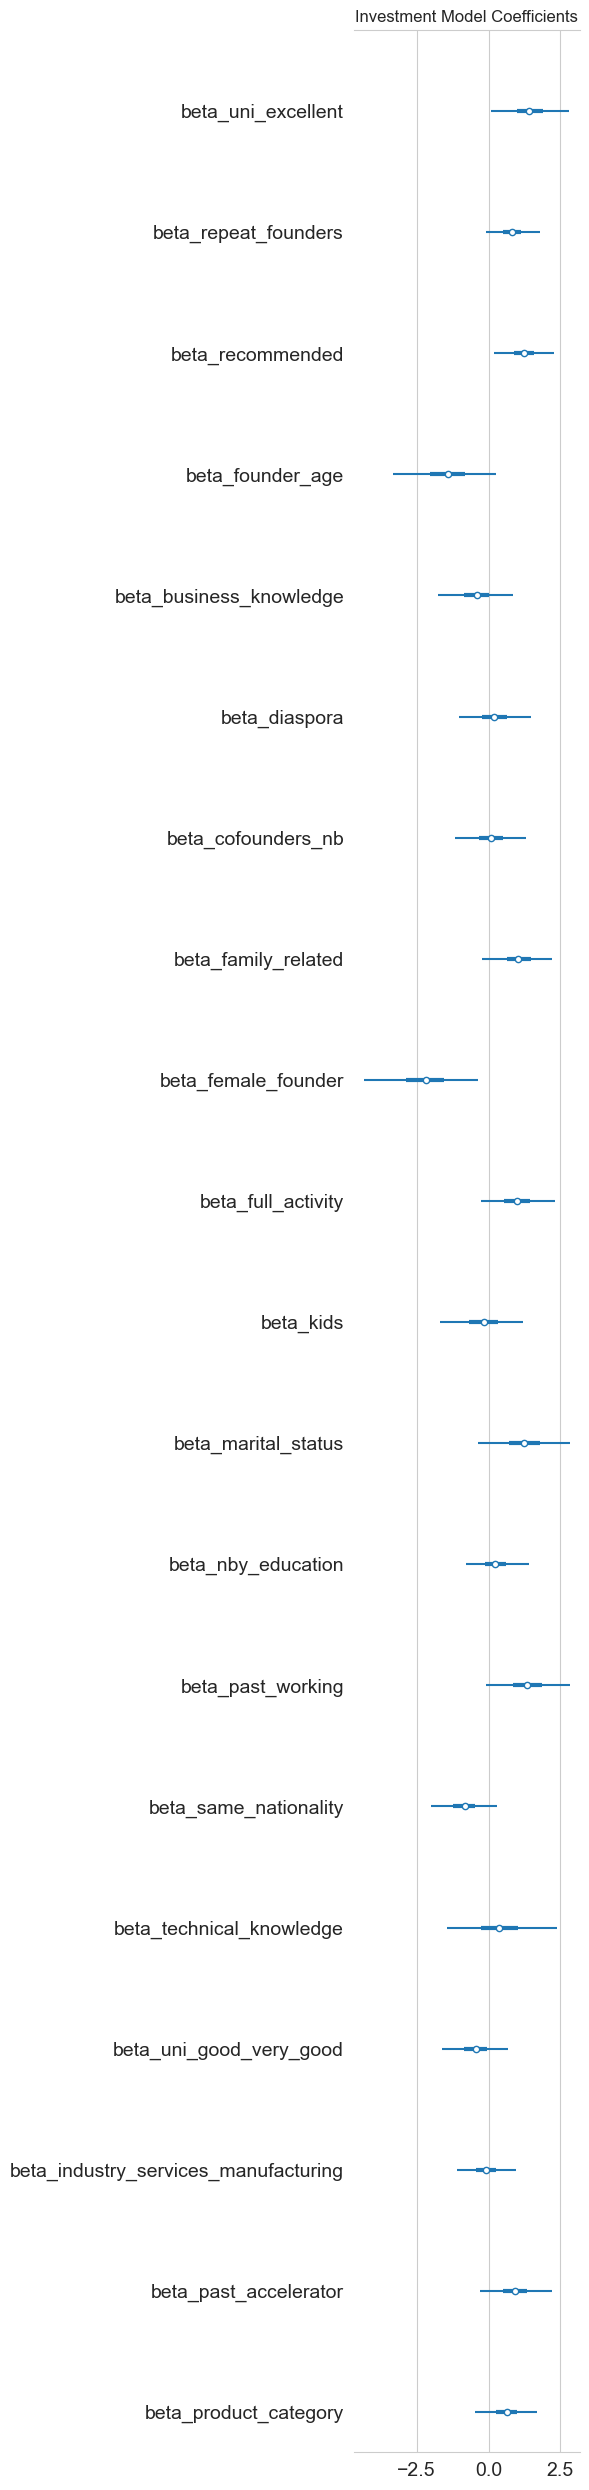

Probability that beta_uni_excellent coefficient > 0: 0.984
Probability that beta_repeat_founders coefficient > 0: 0.966
Probability that beta_recommended coefficient > 0: 0.993
Probability that beta_founder_age coefficient > 0: 0.045
Probability that beta_business_knowledge coefficient > 0: 0.265
Probability that beta_diaspora coefficient > 0: 0.627
Probability that beta_cofounders_nb coefficient > 0: 0.549
Probability that beta_family_related coefficient > 0: 0.961
Probability that beta_female_founder coefficient > 0: 0.009
Probability that beta_full_activity coefficient > 0: 0.948
Probability that beta_kids coefficient > 0: 0.419
Probability that beta_marital_status coefficient > 0: 0.944
Probability that beta_nby_education coefficient > 0: 0.662
Probability that beta_past_working coefficient > 0: 0.972
Probability that beta_same_nationality coefficient > 0: 0.059
Probability that beta_technical_knowledge coefficient > 0: 0.651
Probability that beta_uni_good_very_good coefficient > 0

In [44]:
import arviz as az
import matplotlib.pyplot as plt

# Function to plot forest plots and calculate probabilities for coefficients
def plot_forest_and_calc_probs(trace, model_type="Revenue"):
    # Define model-specific coefficients
    if model_type == "Revenue":
        beta_names = ['beta_full_activity', 'beta_uni_good_very_good', 'beta_product_category','beta_family_related' , 'beta_technical_knowledge' ]
    elif model_type == "Investment":
        beta_names = ['beta_uni_excellent', 'beta_repeat_founders', 'beta_recommended']
    else:
        raise ValueError("Invalid model_type. Choose either 'Revenue' or 'Investment'.")

    # Add 'beta_other' dynamically based on available predictors
    other_predictors = [p for p in trace.posterior.keys() if p.startswith("beta_") and p not in beta_names]
    beta_names += other_predictors

    # Plot Forest Plot
    az.plot_forest(trace, var_names=beta_names, combined=True, hdi_prob=0.95)
    plt.title(f"{model_type} Model Coefficients")
    plt.tight_layout()
    plt.show()

    # Calculate and print probability that each coefficient is greater than zero
    for beta_name in beta_names:
        prob_greater_than_zero = (trace.posterior[beta_name] > 0).mean().values
        print(f"Probability that {beta_name} coefficient > 0: {prob_greater_than_zero:.3f}")

# Plot and calculate for Revenue Model
plot_forest_and_calc_probs(new_trace_rev, model_type="Revenue")

# Plot and calculate for Investment Model
plot_forest_and_calc_probs(trace_inv, model_type="Investment")


In [45]:
## Predictive Performance of the investment acquisition model

C:\Users\hibaa\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sampling: [y_obs]


Output()

AUC: 0.9012
Accuracy: 0.8533
Precision: 0.8125
Recall: 0.6190


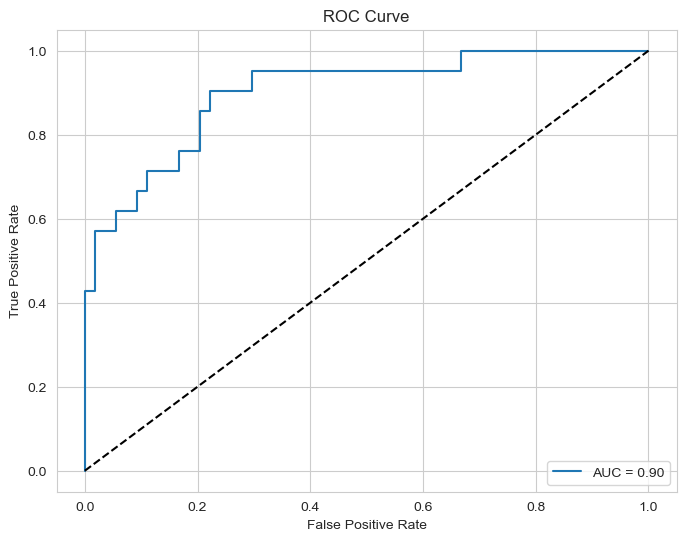

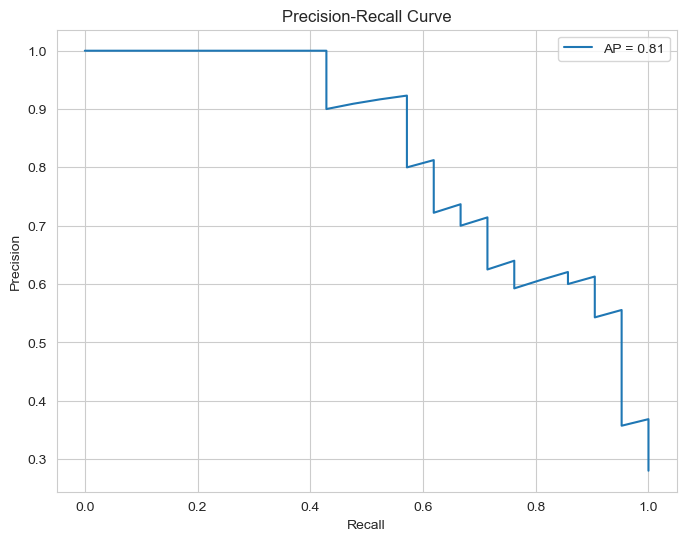

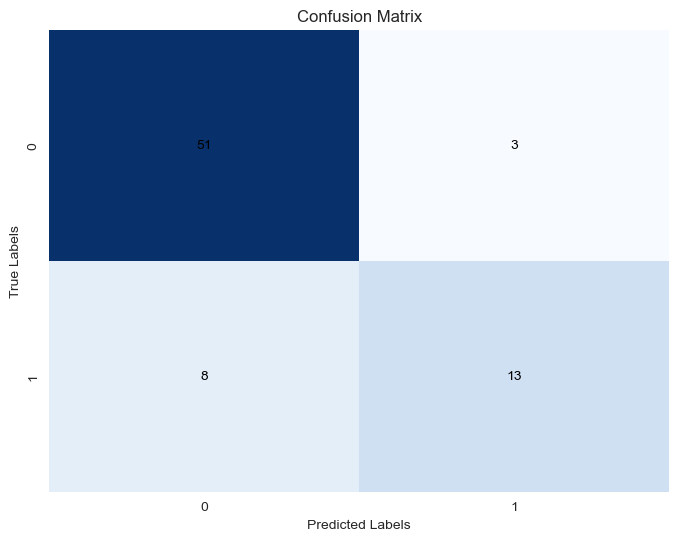

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        54
           1       0.81      0.62      0.70        21

    accuracy                           0.85        75
   macro avg       0.84      0.78      0.80        75
weighted avg       0.85      0.85      0.85        75



In [51]:
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report


# Extract posterior predictive samples
with External_investment_model:
    posterior_predictive = pm.sample_posterior_predictive(trace_inv)

# Use the correct key 'y_obs' to calculate the mean predicted probability
p_mean = posterior_predictive.posterior_predictive['y_obs'].mean(axis=(0, 1))

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred = (p_mean > 0.5).astype(int)

# Calculate evaluation metrics
auc = roc_auc_score(y, p_mean)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Generate and save ROC Curve
fpr, tpr, thresholds = roc_curve(y, p_mean)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve.png')  # Save the ROC Curve as a PNG file
plt.show()

# Generate and save Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y, p_mean)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f"AP = {precision:.2f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('precision_recall_curve.png')  # Save the Precision-Recall Curve as a PNG file
plt.show()

# Generate and save Confusion Matrix Visualization with blue and yellow colors
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"color": "black"})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')  # Save the Confusion Matrix as a PNG file
plt.show()

# Classification Report
class_report = classification_report(y, y_pred)
print("Classification Report:")
print(class_report)
